In [1]:
import glob
from collections import OrderedDict

import ROOT
ROOT.gROOT.SetBatch(True)
from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F, TH1D, TH2D, THStack, TF1
from ROOT import gBenchmark, gRandom, gSystem, Double, gPad, TFitResultPtr, TMath
import root_numpy
import psutil
import pandas
import math
#matplotlib.use('agg')
%matplotlib inline
import matplotlib #as matplot
print(matplotlib.__version__)
#print(matplotlib.path)
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import numpy as np
import time
from datetime import datetime

from sklearn.metrics import roc_curve, auc
import pylab
import sklearn as sk
print(sk.__version__)
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)
######################
import keras as kr
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ELU, PReLU 
from keras.optimizers import Adamax
from keras.optimizers import Nadam
print(kr.__version__)
#from keras import backend as K
import tensorflow as tf
print(tf.__version__)
config = tf.ConfigProto(intra_op_parallelism_threads=32, \
                        inter_op_parallelism_threads=32, \
                        allow_soft_placement=True, \
                        device_count = {'CPU': 32}
                       )
session = tf.Session(config=config)
#K.set_session(session)
## it will issue a warning, just ignore

Welcome to JupyROOT 6.12/07
1.5.2
0.19.1
1.6.0
2.1.4
1.6.0


Using TensorFlow backend.


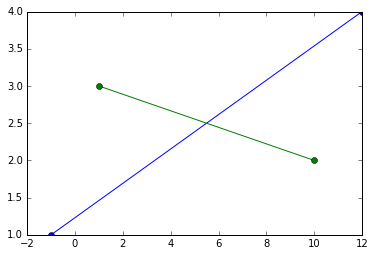

In [2]:
# test that matplotlib imported ok
x1, y1 = [-1, 12], [1, 4]
x2, y2 = [1, 10], [3, 2]
plt.plot(x1, y1, x2, y2, marker = 'o')
plt.show()

In [3]:
channel='2l_2tau_HH'

startTime = datetime.now()
execfile("../python/data_manager.py") 

if channel=='2l_2tau_HH' : 
    execfile("../cards/info_2l_2tau_HH.py") 
    execfile("../cards/auxiliary_functions_2l_2tau_HH.py") ## Loading the functions and setup variables specific to 2l_2tau channels 
    execfile("../cards/NN_settings_2l_2tau_HH.py") ## Loading the boolean settings specific to 2l_2tau channel
    
log_file_name=channel+".log"
if 'evtLevelSUM_HH_2l_2tau_res' in bdtType:
    file1_ = open(log_file_name, 'w+')
else: 
    file1_ = open('roc.log','w+')    


import shutil,subprocess
proc=subprocess.Popen(['mkdir '+channel],shell=True,stdout=subprocess.PIPE)
out = proc.stdout.read()    
    
    
output = read_from(Bkg_mass_rand, tauID)

mkdir: cannot create directory `2l_2tau_HH': File exists


In [4]:
print ("read from:", output["inputPath"])
print ("Date: ", time.asctime( time.localtime(time.time()) ))

if(TrainMode == 0): ## All Masses included in training 
    data=load_data_2017(
            output["inputPath"],
            output["channelInTree"],
            trainVars(True),
            [],
            bdtType,
            channel,
            output["keys"],
            output["masses"],
            output["mass_randomization"],
            )
    mass_list = output["masses"]
    test_masses = output["masses_test"]
elif(TrainMode == 1): ## Only Low Masses (<= 400 GeV) included in training                                                                                                                                                                                              
        data=load_data_2017(
            output["inputPath"],
            output["channelInTree"],
            trainVars(True),
            [],
            bdtType,
            channel,
            output["keys"],
            output["masses_low"],
            output["mass_randomization"],
            )
        mass_list = output["masses_low"]
        test_masses = output["masses_test_low"]
elif(TrainMode == 2): ## Only High Masses (> 400 GeV) included in training                                                                                                                                                                                              
        data=load_data_2017(
            output["inputPath"],
            output["channelInTree"],
            trainVars(True),
            [],
            bdtType,
            channel,
            output["keys"],
            output["masses_high"],
            output["mass_randomization"],
            )
        mass_list = output["masses_high"]
        test_masses = output["masses_test_high"]
else:        
    data=load_data_2017(
        output["inputPath"], 
        output["channelInTree"], 
        trainVars(True), 
        [], 
        bdtType, 
        channel,
        output["keys"], 
        output["masses"],
        output["mass_randomization"]
        ) # note: I had to add channel as argument of the function
    mass_list = output["masses"]
    test_masses = output["masses_test"]
    
    
#data.dropna(subset=["totalWeight"],inplace = True) ## Was used in the BDT code
#data.fillna(0)                                     ## Was used in the BDT code

print (len(data))
print ("Date: ", time.asctime( time.localtime(time.time()) ))

('read from:', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/')
('Date: ', 'Fri Oct 18 15:06:49 2019')
In data_manager::load_data_2017()::
 inputPath:  /hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/ 
 channelInTree:  hh_2l_2tau_sumOS_forBDTtraining
 variables:  ['lep1_pt', 'lep1_conePt', 'lep1_eta', 'lep1_tth_mva', 'mT_lep1', 'lep2_pt', 'lep2_conePt', 'lep2_eta', 'lep2_tth_mva', 'mT_lep2', 'tau1_pt', 'tau1_eta', 'tau1_mva', 'tau2_pt', 'tau2_eta', 'tau2_mva', 'dr_lep1_tau1', 'dr_lep1_tau2', 'dr_lep2_tau1', 'dr_lep2_tau2', 'min_dr_lep_tau', 'max_dr_lep_tau', 'dr_leps', 'dr_taus', 'avg_dr_jet', 'met', 'mht', 'met_LD', 'HT', 'STMET', 'Smin_llMEt', 'm_ll', 'pT_ll', 'pT_llMEt', 'Smin_lltautau', 'mTauTauVis', 'ptTauTauVis', 'diHiggsVisMass', 'diHiggsMass', 'logTopness_publishedChi2', 'logTopness_fixedChi2', 'genWeight', 'evt

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:233: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:234: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:235: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pyda

('TTTo2L2Nu', 'size of sig, bkg, evtweight, tot weight of data: ', 0, 96354, 3728.0159, 3728.0159)
('TTTo2L2Nu', 'events with -ve weights', 1494)
('(folderName, channelTree) = ', ('TTToSemiLeptonic', 'hh_2l_2tau_sumOS_forBDTtraining'))
inputPath: /hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/  folderName: TTToSemiLeptonic 
i/p nTuples : ['/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/TTToSemiLeptonic/TTToSemiLeptonic_disabled_disabled_forBDTtraining_OS_central_1.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/TTToSemiLeptonic/TTToSemiLeptonic_disabled_disabled_forBDTtraining_OS_central_2.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/TTToS

('DY', 'size of sig, bkg, evtweight, tot weight of data: ', 0, 12798, 2459.6665, 2459.6665)
('DY', 'events with -ve weights', 234)
('(folderName, channelTree) = ', ('ZZ', 'hh_2l_2tau_sumOS_forBDTtraining'))
inputPath: /hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/  folderName: ZZ 
i/p nTuples : ['/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/ZZTo2L2Nu/ZZTo2L2Nu_disabled_disabled_forBDTtraining_OS_central_1.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/ZZTo2L2Q/ZZTo2L2Q_disabled_disabled_forBDTtraining_OS_central_1.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/ZZTo2L2Q/ZZTo2L2Q_disabled_disabled_forBDTtraining_OS_central_2.root', '/hdfs/

('WZ', 'size of sig, bkg, evtweight, tot weight of data: ', 0, 45234, 218.62016, 218.62016)
('WZ', 'events with -ve weights', 4500)
('(folderName, channelTree) = ', ('signal_ggf_spin0_250_hh_4t', 'hh_2l_2tau_sumOS_forBDTtraining'))
inputPath: /hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/  folderName: signal_ggf_spin0_250_hh_4t 
i/p nTuples : ['/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/signal_ggf_spin0_250_hh_4t/signal_ggf_spin0_250_hh_4t_disabled_disabled_forBDTtraining_OS_central_1.root']
('signal_ggf_spin0_250_hh_4t', 'size of sig, bkg, evtweight, tot weight of data: ', 1851, 0, 0.49648058, 0.49648058)
('signal_ggf_spin0_250_hh_4t', 'events with -ve weights', 44)
('(folderName, channelTree) = ', ('signal_ggf_spin0_260_hh_4t', 'hh_2l_2tau_sumOS_forBDTtraining'))
inputPath: /hdfs/local/ram/hhAnalysis/2017/2019Feb4

('signal_ggf_spin0_650_hh_4t', 'size of sig, bkg, evtweight, tot weight of data: ', 3006, 0, 1.8413217, 1.8413217)
('signal_ggf_spin0_650_hh_4t', 'events with -ve weights', 26)
('(folderName, channelTree) = ', ('signal_ggf_spin0_700_hh_4t', 'hh_2l_2tau_sumOS_forBDTtraining'))
inputPath: /hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/  folderName: signal_ggf_spin0_700_hh_4t 
i/p nTuples : ['/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/signal_ggf_spin0_700_hh_4t/signal_ggf_spin0_700_hh_4t_disabled_disabled_forBDTtraining_OS_central_1.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/signal_ggf_spin0_700_hh_4t_private/signal_ggf_spin0_700_hh_4t_private_disabled_disabled_forBDTtraining_OS_central_1.root']
('signal_ggf_spin0_700_hh_4t',

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:240: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:241: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


('hh_2l_2tau_sumOS_forBDTtraining', ' size of sig, bkg: ', 52695, 634842)
687537
('Date: ', 'Fri Oct 18 15:13:23 2019')


In [5]:
plotAll=False
BDTvariables=trainVars(plotAll, variables, bdtType)

import copy

## Removing gen_mHH from the list of input variables                                                                                                                                                                                                                    
BDTvariables_wo_gen_mHH = copy.deepcopy(BDTvariables)  ## Works                                                                                                                                                                                                         
BDTvariables_wo_gen_mHH.remove("gen_mHH")

trainvar = variables

if channel=='2l_2tau_HH' :
    labelBKG = "TT+DY+VV"
else:
    labelBKG = "TT+DY+VV+W"
    
print("mass_list", mass_list)
print("test_masses", test_masses)

if((channel=='2l_2tau_HH') and do_ReweightVars):
        DoFits = True
        print DoFits
        print("Perfoming Fits to TProfile plots for signal")
        ## --- Making TProfile plots with fits (Signal) --- ###
        MakeTProfile_New(channel, data, BDTvariables_wo_gen_mHH, 1, DoFits, "before", TrainMode, mass_list)
else:
        DoFits = False
        print DoFits
        print("Not Perfoming Fits to TProfile plots for signal")

        
        

if((channel=='2l_2tau_HH') and do_2l_2tau_diagnostics == True):  
    ## --- Making TProfile plots w/o fits (background) --- ###                                                                                                                                           
    MakeTProfile_New(channel, data, BDTvariables_wo_gen_mHH, 0, False, "before", TrainMode, mass_list)        

    ## --- Making 1D Histo plots (background) --- ###                                                                                                                                                                                                                   
    MakeHisto1D_New(channel, data, BDTvariables, "before")

    ## --- Making 1D THStack plots (background) --- ###                                                                                                                                                                                                                 
    MakeTHStack_New(channel, data, BDTvariables, "before")
else:
    print("No plots will be made for 2l_2tau diagnostics")  

if((channel=='2l_2tau_HH') and do_ReweightVars):
    ## ----- SCALING I/P VAR.S IN DATA USING THE FITS DONE ABOVE---- ###                                                                                                                                                                                            
    ReweightDataframe_New(data, channel, BDTvariables_wo_gen_mHH, mass_list)
else:
    print("No plots and fits will be made for 2l_2tau diagnostics")
    
    
weights="evtWeight"

print ("Date: ", time.asctime( time.localtime(time.time()) ))
data["weight_cx"] = data[weights]
data["weight_train"] = data[weights]
data["NN_output"] = 1.0

print ("separate datasets odd/even")
data_even = data.loc[(data["event"].values % 2 == 0) ]
data_odd = data.loc[~(data["event"].values % 2 == 0) ]

order_train = [data_odd, data_even]
order_train_name = ["odd","even"]


print ("balance datasets by even/odd chunck")
for data_do in order_train :
    #### Normalization by cross section                                                                                                                                                                                                                                   
    for wei in ["weight_cx", "weight_train"] :
        if 'SUM_HH' in bdtType :
            data_do.loc[(data_do['key'].isin(['TTTo2L2Nu','TTToSemiLeptonic'])), [wei]]              *= output["TTdatacard"]/data_do.loc[(data_do['key'].isin(['TTTo2L2Nu','TTToSemiLeptonic'])), weights].sum()
            data_do.loc[(data_do['key']=='DY'), [wei]]                            *= output["DYdatacard"]/data_do.loc[(data_do['key']=='DY'), weights].sum()
            if "evtLevelSUM_HH_bb1l_res" in bdtType :
                data_do.loc[(data_do['key']=='W'), [wei]]                         *= Wdatacard/data_do.loc[(data_do['key']=='W')].sum() ## Saswati check please !!!                                                                                                       
        if "evtLevelSUM_HH_2l_2tau_res" in bdtType :
               #data_do.loc[(data_do['key']=='TTZJets'), [wei]]                       *= output["TTZdatacard"]/data_do.loc[(data_do['key']=='TTZJets'), weights].sum() ## TTZJets                                                                                          
               #data_do.loc[(data_do['key']=='TTWJets'), [wei]]                       *= output["TTWdatacard"]/data_do.loc[(data_do['key']=='TTWJets'), weights].sum() ## TTWJets + TTWW                                                                                   
               data_do.loc[(data_do['key']=='ZZ'), [wei]]                            *= output["ZZdatacard"]/data_do.loc[(data_do['key']=='ZZ'), weights].sum() ## ZZ +ZZZ                                                                                                
               data_do.loc[(data_do['key']=='WZ'), [wei]]                            *= output["WZdatacard"]/data_do.loc[(data_do['key']=='WZ'), weights].sum() ## WZ + WZZ_4F                                                                                            
               data_do.loc[(data_do['key']=='WW'), [wei]]                            *= output["WWdatacard"]/data_do.loc[(data_do['key']=='WW'), weights].sum() ## WW + WWZ + WWW_4F                                                                                      
               #data_do.loc[(data_do['key']=='VH'), [wei]]                        *= output["VHdatacard"]/data_do.loc[(data_do['key']=='VH'), weights].sum() # consider removing                                                                                          
               #data_do.loc[(data_do['key']=='TTH'), [wei]]                       *= output["TTHdatacard"]/data_do.loc[(data_do['key']=='TTH'), weights].sum() # consider removing    
    ### Normalize sig/BKG and do table of nevents/mass
    for mass in output["masses"] :
        data_do.loc[(data_do['target']==1) & (data_do["gen_mHH"] == mass),"weight_train"] *= 10000./data_do.loc[(data_do['target']==1) & (data_do["gen_mHH"]== mass), "weight_train"].sum() ## Changed from 1000
        data_do.loc[(data_do['target']==0) & (data_do["gen_mHH"] == mass),"weight_train"] *= 10000./data_do.loc[(data_do['target']==0) & (data_do["gen_mHH"]== mass), "weight_train"].sum() ## Changed from 1000 
    print ("Date: ", time.asctime( time.localtime(time.time()) ))

    print ("training statistics by mass")
    for mass in output["masses"] :
        print (
               str(mass)+": sig = "+\
               str(len(data_do.loc[(data['target']==1) & (data_do["gen_mHH"] == mass),["weight_train"]]))+\
               " BKG = "+str(len(data_do.loc[(data['target']==0) & (data_do["gen_mHH"] == mass),["weight_train"]]))
              )

    print ("\n norm by mass - test")
    for mass in output["masses"] :
        print (
               str(mass)+": sig = "+\
               str(data_do.loc[(data_do['target']==1) & (data_do["gen_mHH"] == mass),"weight_train"].sum())+\
               " BKG = "+str(data_do.loc[(data_do['target']==0) & (data_do["gen_mHH"] == mass),"weight_train"].sum())
              )

if((channel=='2l_2tau_HH') and do_2l_2tau_diagnostics == True):        
    ## ----Merging the odd and even data-sets ---------------------------------------####                                                                                                                                                                               
    ## ---(reweighting the merged dataframe by 0.5 as it is derived from 2 halves) ---###                                                                                                                                                                               
    data_odd_copy = data_odd.copy(deep=True) ## Making sure we do not alter the halves used for roc curves later                                                                                                                                                        
    data_even_copy = data_even.copy(deep=True) ## Making sure we do not alter the halves used for roc curves later                                                                                                                                                      
    data_do = data_odd_copy.append(data_even_copy, ignore_index=True)
    data_do.loc[data_do['target']==0, [weights]] *= 0.5
    data_do.loc[data_do['target']==1, [weights]] *= 0.5
    label = "after"

    ## --- Making TProfile plots w/o fitting (Signal) --- ###                                                                                                                                                                                                           
    MakeTProfile_New(channel, data, BDTvariables_wo_gen_mHH, 1, False, label, TrainMode, mass_list)

    ## --- Making TProfile plots (background) --- ###                                                                                                                                                                                                                   
    MakeTProfile_New(channel, data, BDTvariables_wo_gen_mHH, 0, False, label, TrainMode, mass_list)

    ## --- Making 1D Histo plots (background) --- ###                                                                                                                                                                                                                   
    MakeHisto1D_New(channel, data,  BDTvariables, label)

    ## --- Making 1D THStack plots (background) --- ###                                                                                                                                                                                                                 
    MakeTHStack_New(channel, data, BDTvariables, label)
else:
    print("No plots will be made for 2l_2tau diagnostics")    
    


('mass_list', [250, 260, 270, 280, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 1000])
('test_masses', [300, 500, 800])
True
Perfoming Fits to TProfile plots for signal
Variable Name: diHiggsMass
('fitFuncName', 'fitFunction_diHiggsMass')
Variable Name: diHiggsVisMass
('fitFuncName', 'fitFunction_diHiggsVisMass')
Variable Name: tau1_pt
('fitFuncName', 'fitFunction_tau1_pt')
Variable Name: nBJet_medium
('fitFuncName', 'fitFunction_nBJet_medium')
Variable Name: nElectron
('fitFuncName', 'fitFunction_nElectron')
Variable Name: dr_lep_tau_min_SS
('fitFuncName', 'fitFunction_dr_lep_tau_min_SS')
Variable Name: met_LD
('fitFuncName', 'fitFunction_met_LD')
Variable Name: tau2_pt
('fitFuncName', 'fitFunction_tau2_pt')
Variable Name: dr_lep_tau_min_OS
('fitFuncName', 'fitFunction_dr_lep_tau_min_OS')
Variable Name: diHiggsMass
('fitFuncName', 'fitFunction_diHiggsMass')
No fit will be performed
Variable Name: diHiggsVisMass
('fitFuncName', 'fitFunction_diHiggsVisMass')
No fit w

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-pandas/0.23.0/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


('Date: ', 'Fri Oct 18 15:14:32 2019')
training statistics by mass
250: sig = 960 BKG = 17585
260: sig = 895 BKG = 17585
270: sig = 862 BKG = 17585
280: sig = 904 BKG = 17585
300: sig = 720 BKG = 17585
350: sig = 846 BKG = 17585
400: sig = 2549 BKG = 17585
450: sig = 1331 BKG = 17585
500: sig = 1047 BKG = 17585
550: sig = 1212 BKG = 17585
600: sig = 1337 BKG = 17585
650: sig = 1541 BKG = 17585
700: sig = 4171 BKG = 17585
750: sig = 1836 BKG = 17585
800: sig = 1923 BKG = 17585
850: sig = 1980 BKG = 17585
900: sig = 1048 BKG = 17585
1000: sig = 1221 BKG = 17585

 norm by mass - test
250: sig = 10000.0 BKG = 10000.001
260: sig = 10000.0 BKG = 10000.001
270: sig = 9999.999 BKG = 10000.001
280: sig = 10000.0 BKG = 10000.001
300: sig = 10000.0 BKG = 10000.001
350: sig = 10000.0 BKG = 10000.001
400: sig = 10000.0 BKG = 10000.001
450: sig = 10000.0 BKG = 10000.001
500: sig = 10000.0 BKG = 10000.001
550: sig = 10000.0 BKG = 10000.001
600: sig = 10000.0 BKG = 10000.001
650: sig = 10000.001 BKG =

Info in <TCanvas::SaveAs>: ROOT file 2l_2tau_HH/TProfile_signal_diHiggsMass_before.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: hprof (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file 2l_2tau_HH/TProfile_signal_diHiggsVisMass_before.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: hprof (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file 2l_2tau_HH/TProfile_signal_tau1_pt_before.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: hprof (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file 2l_2tau_HH/TProfile_signal_nBJet_medium_before.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: hprof (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file 2l_2tau_HH/TProfile_signal_nElectron_before.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: hprof (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file 2l_2tau_HH/TProfile_signa

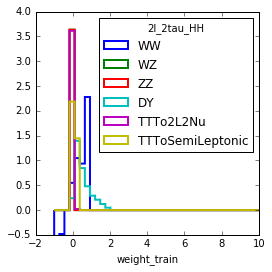

In [6]:
"""
Check of the resulting weights - the sizes of the training weight
"""
fig, ax = plt.subplots(figsize=(4, 4))
if(channel=='2l_2tau_HH'):
    keysToBKG = ['WW', 'WZ', 'ZZ', 'DY', 'TTTo2L2Nu', 'TTToSemiLeptonic'] # 'VH', 'TTH', 'TTToHadronic', 'TTZJets', 'TTWJets' 
else:
    keysToBKG = ['WW', 'WZ', 'ZZ', 'DY', 'TTTo2L2Nu', 'TTToSemiLeptonic', 'W']
    
#colors = ['cyan','orange','k','r','green','magenta','b',]
vars = ["weight_train"]#"multitarget"]

for kk, key in enumerate(keysToBKG) :
  for vv, var in enumerate(vars) : 
    ax.hist(
        np.array(data.loc[(data['key']==key), var].values,dtype='float64'), # 
        weights=data.loc[(data['key']==key), "evtWeight"], # "weight_train_cat"
        range=(-1.0,10.),bins=40, histtype='step', normed=True, lw=2, 
        label=key
    )
    ax.set_xlabel(var)
ax.legend(loc="best", title= channel)

In [7]:
## load the variables
#trainvar = trainVars(False, "testVars2")
#print trainvar
trainvar = trainVars(False, variables, bdtType) ## = BDTvariables
print trainvar

['diHiggsMass', 'diHiggsVisMass', 'tau1_pt', 'nBJet_medium', 'gen_mHH', 'nElectron', 'dr_lep_tau_min_SS', 'met_LD', 'tau2_pt', 'dr_lep_tau_min_OS']


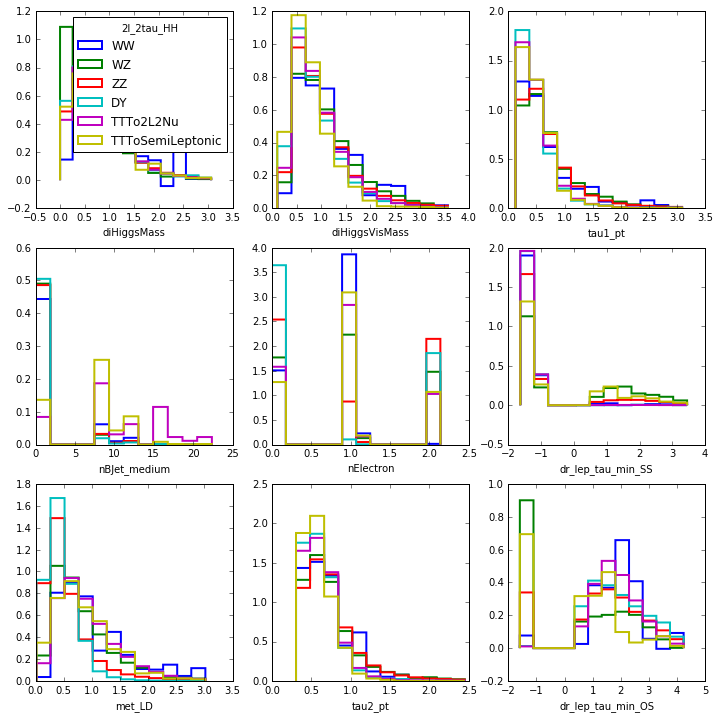

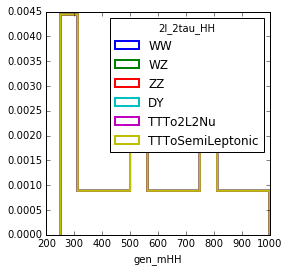

In [8]:
"""
Draw some plots on lists of variables for BKG
"""
#keysToBKG = ['TTZJets', 'WZ', 'ZZ', 'DY', 'VH', 'ttH', 'TTTo2L2Nu']
 
## i try to do 3 X 3 plots (= enter up to nine entries in each sublist)
## try to add strictly decreasing variables as first in each sublist, better for the legend positioning
#listdraw = [
#    [ 'tau1_pt', 'tau2_pt', 'mT_lep1', 'mT_lep2', 'met', 'm_ll', 'mTauTau', 'diHiggsVisMass', 'diHiggsMass' ], 
#    ['nBJet_medium', 'nElectron', 'max_tau_eta', 'max_lep_eta', 'gen_mHH'],
#]

if(channel=='2l_2tau_HH'):
    listdraw = [
        ['diHiggsMass', 'diHiggsVisMass', 'tau1_pt', 'nBJet_medium', 'nElectron', 'dr_lep_tau_min_SS', 'met_LD', 'tau2_pt', 'dr_lep_tau_min_OS'],
        ['gen_mHH'],
               ]
else:
    listdraw = [
        ['diHiggsMass', 'diHiggsVisMass', 'tau1_pt', 'nBJet_medium', 'nElectron', 'dr_lep_tau_min_SS', 'met_LD', 'tau2_pt', 'dr_lep_tau_min_OS'],
        ['gen_mHH'],
               ]

for featuresDraw in listdraw:
    sizeArray=int(math.sqrt(len(featuresDraw))) if math.sqrt(len(featuresDraw)) % int(math.sqrt(len(featuresDraw))) == 0 else int(math.sqrt(len(featuresDraw)))+1
    plt.figure(figsize=(4*sizeArray,4*sizeArray))
    for n, feature in enumerate(featuresDraw) :
        min_value, max_value = np.percentile(data[feature], [0.0, 99])
        # fig, ax = plt.subplots(figsize=(4, 4))
        plt.subplot(sizeArray, sizeArray, n+1)
        for kk, key in enumerate(keysToBKG) :
            if 'TTZJets' in key or 'TTWJets' in key : linestyle = "--"
            else :linestyle = "-"
            plt.hist(
            np.array(data.loc[(data['key']==key), feature].values,dtype='float64'), 
            weights=data.loc[(data['key']==key) , "evtWeight"], 
            range=(min_value, max_value), 
            bins=12, histtype='step', ls=linestyle, 
            normed=True, lw=2, #color=colors[kk],
            label=key
            )
            plt.xlabel(feature)
        if n == 0 : plt.legend(loc="upper right", title= channel)

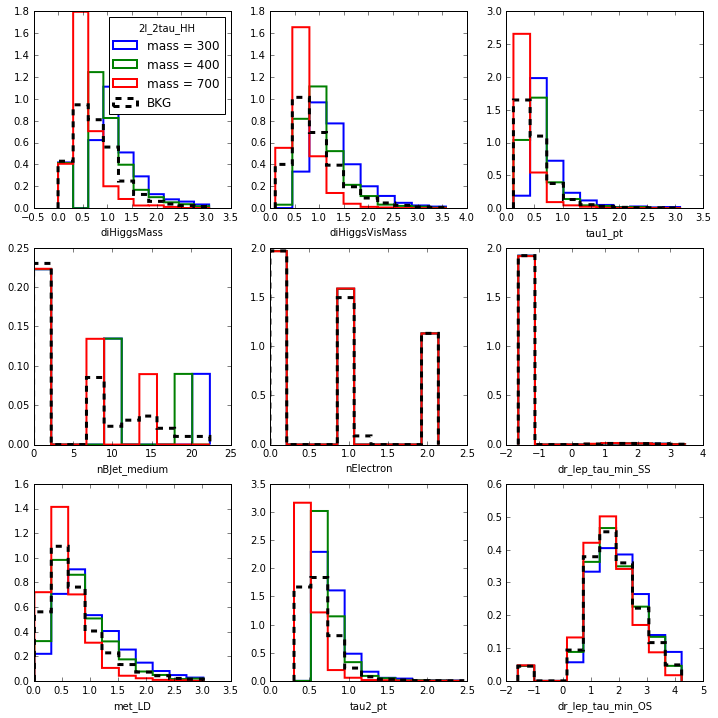

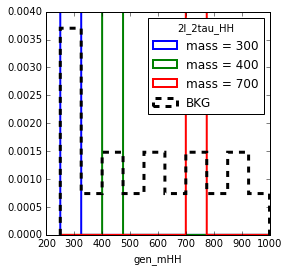

In [9]:
for featuresDraw in listdraw:
    sizeArray=int(math.sqrt(len(featuresDraw))) if math.sqrt(len(featuresDraw)) % int(math.sqrt(len(featuresDraw))) == 0 else int(math.sqrt(len(featuresDraw)))+1
    plt.figure(figsize=(4*sizeArray,4*sizeArray))
    for n, feature in enumerate(featuresDraw) :
        min_value, max_value = np.percentile(data[feature], [0.0, 99])
        # fig, ax = plt.subplots(figsize=(4, 4))
        plt.subplot(sizeArray, sizeArray, n+1)
        for mass in [300,400,700] :
            plt.hist(
            np.array(data.loc[(data["gen_mHH"] == mass), feature].values,dtype='float64'), 
            weights=data.loc[(data["gen_mHH"] == mass) , "evtWeight"], 
            range=(min_value, max_value), 
            bins=10, histtype='step', ls=linestyle, 
            normed=True, lw=2, #color=colors[kk],
            label="mass = "+str(mass)
            )
        plt.hist(
        np.array(data.loc[(data['target']==0), feature].values,dtype='float64'), 
        weights=data.loc[(data['target']==0) , "evtWeight"], 
        range=(min_value, max_value), 
        bins=10, histtype='step', ls='--', 
        normed=True, lw=3, color='k',
        label="BKG"
        )
        plt.xlabel(feature)
        if n == 0 : plt.legend(loc="upper right", title= channel)

In [10]:
# create model -- for binary activation='sigmoid'
nclasses = 1

## ---- Set these values for NN hyper-parameters (for gen_mHH as Input Var.) --- ##                                                                                                                                                                                                                     
EPOCHS=100 # 50 is more optimum
DROPOUT=0.05 # 0.01 is more optimum
LR=0.00005
SCHEDULE_DECAY=0.000005
BATCH_SIZE=256 
#EPOCHS=35
#DROPOUT=0.01
#LR=0.0005
#SCHEDULE_DECAY=0.00005
#BATCH_SIZE=256 ## 32,256
##----------------------------------------------------------##       

## ---- Set these values for NN hyper-parameters (w/o gen_mHH as Input Var.) --- ##                                                                                                                                                                                                                     
EPOCHS2=35
DROPOUT2=0.01
LR2=0.0005
SCHEDULE_DECAY2=0.00005
BATCH_SIZE2=256 ## 32,256
##----------------------------------------------------------##       


hyppar=str(variables)+"_epochs_"+str(EPOCHS)+"_dropout_"+num_to_str(DROPOUT)+"_lr_"+num_to_str(LR)+"_sch_decay_"+num_to_str(SCHEDULE_DECAY)+"_batch_size_"+str(BATCH_SIZE)
hyppar2=str(variables)+"_wo_gen_mHH"+"_epochs_"+str(EPOCHS2)+"_dropout_"+num_to_str(DROPOUT2)+"_lr_"+num_to_str(LR2)+"_sch_decay_"+num_to_str(SCHEDULE_DECAY2)+"_batch_size_"+str(BATCH_SIZE2)

print hyppar
print("DROPOUT", DROPOUT)
print("LR", LR)
print("SCHEDULE_DECAY", SCHEDULE_DECAY)

print hyppar2
print("DROPOUT2", DROPOUT2)
print("LR2", LR2)
print("SCHEDULE_DECAY2", SCHEDULE_DECAY2)


features = trainvar # = BDTvariables
features2 = BDTvariables_wo_gen_mHH

def nn_model_binary():
    "create a model."
    model = Sequential()
    model.add(Dense(2*len(features), input_dim=len(features), kernel_initializer='he_uniform')) 
    model.add(BatchNormalization())
    model.add(PReLU())
    model.add(Dropout(DROPOUT)) #0.1
    for Nnodes in [8,8] :
        model.add(Dense(Nnodes, kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(PReLU())
        model.add(Dropout(DROPOUT)) #0.1
    model.add(Dense(nclasses, activation='sigmoid'))
    model.compile(
    loss='binary_crossentropy', 
    optimizer=Nadam(lr=LR, schedule_decay=SCHEDULE_DECAY), ##  lr=0.0005, sch_dec.=0.00005   # , beta_1 = 0.95, beta_2 = 0.999
    metrics=['accuracy'], 
    )
    return model

def nn_model_binary_wo_gen_mHH():
    "create a model."
    model = Sequential()
    model.add(Dense(2*len(features2), input_dim=len(features2), kernel_initializer='he_uniform')) 
    model.add(BatchNormalization())
    model.add(PReLU())
    model.add(Dropout(DROPOUT2)) #0.1
    for Nnodes in [8,8] :
        model.add(Dense(Nnodes, kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(PReLU())
        model.add(Dropout(DROPOUT2)) #0.1
    model.add(Dense(nclasses, activation='sigmoid'))
    model.compile(
    loss='binary_crossentropy', 
    optimizer=Nadam(lr=LR2, schedule_decay=SCHEDULE_DECAY2), ##  lr=0.0005, sch_dec.=0.00005   # , beta_1 = 0.95, beta_2 = 0.999
    metrics=['accuracy'], 
    )
    return model

finalVars_allMasses_epochs_100_dropout_0o05_lr_5e-05_sch_decay_5e-06_batch_size_256
('DROPOUT', 0.05)
('LR', 5e-05)
('SCHEDULE_DECAY', 5e-06)
finalVars_allMasses_wo_gen_mHH_epochs_35_dropout_0o01_lr_0o0005_sch_decay_5e-05_batch_size_256
('DROPOUT2', 0.01)
('LR2', 0.0005)
('SCHEDULE_DECAY2', 5e-05)


In [11]:
nn_model_binary().summary()
nn_model_binary_wo_gen_mHH().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 20)                20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 168       
_________________________________________________________________
batch_normalization_2 (Batch (None, 8)                 32        
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 8)                 8         
__________

In [12]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler

In [13]:
# Port Keras Framework into SK-Learn
# https://stackoverflow.com/questions/39467496/error-when-using-keras-sk-learn-api
k_model_binary  = KerasClassifier(
    build_fn=nn_model_binary, ## For gen_mHH as input Var.
    epochs=EPOCHS,            ## For gen_mHH as input Var.
    batch_size=BATCH_SIZE,    ## For gen_mHH as input Var.
    verbose=2                 ## For gen_mHH as input Var.
    #build_fn=nn_model_binary_wo_gen_mHH, ## w/o gen_mHH as input Var.
    #epochs=EPOCHS2,                      ## w/o gen_mHH as input Var. 
    #batch_size=BATCH_SIZE2,              ## w/o gen_mHH as input Var.
    #verbose=2                            ## w/o gen_mHH as input Var.
)

k_model_binary2  = KerasClassifier(
    build_fn=nn_model_binary, ## For gen_mHH as input Var.
    epochs=EPOCHS,            ## For gen_mHH as input Var. 
    batch_size=BATCH_SIZE,    ## For gen_mHH as input Var.
    verbose=2                 ## For gen_mHH as input Var.
    #build_fn=nn_model_binary_wo_gen_mHH, ## w/o gen_mHH as input Var.
    #epochs=EPOCHS2,                      ## w/o gen_mHH as input Var. 
    #batch_size=BATCH_SIZE2,              ## w/o gen_mHH as input Var.
    #verbose=2                            ## w/o gen_mHH as input Var.


)

print("data_odd[features].values", data_odd[features].values)
print("data_odd[target].values", data_odd['target'].values)
print("sample_weight=data_odd[weight_train].values", data_odd["weight_train"].values)

history = k_model_binary.fit(
    data_odd[features].values, ## For gen_mHH as input Var.
    #data_odd[features2].values, ## w/o gen_mHH as input Var.
    data_odd['target'].values,
    sample_weight=data_odd["weight_train"].values,
    validation_data=(
        data_even[features].values, ## For gen_mHH as input Var.
        #data_even[features2].values, ## w/o gen_mHH as input Var.
        data_even['target'].values, 
        data_even["weight_train"].values
    )
)


history2 = k_model_binary2.fit(
    data_even[features].values, ## For gen_mHH as input Var.
    #data_even[features2].values, ## w/o gen_mHH as input Var.
    data_even['target'].values,
    sample_weight=data_even["weight_train"].values,
    validation_data=(
        data_odd[features].values, ## For gen_mHH as input Var.
        #data_odd[features2].values,  ## w/o gen_mHH as input Var. 
        data_odd['target'].values, 
        data_odd["weight_train"].values
    )
)


('data_odd[features].values', array([[0.8094199895858765, 1.2075021266937256, 0.6241664886474609, ...,
        0.8703704476356506, 0.8964957594871521, 3.7127585411071777],
       [0.9430416226387024, 1.5530486106872559, 1.1408418416976929, ...,
        1.7482539415359497, 1.0562164783477783, 1.7053056955337524],
       [1.2136162519454956, 1.1606113910675049, 0.45046108961105347, ...,
        0.9329136610031128, 0.6422618627548218, 2.0226306915283203],
       ...,
       [1.1580690145492554, 0.5099794268608093, 0.7377614974975586, ...,
        0.9948492646217346, 0.31968697905540466, -1.5872480869293213],
       [1.153649926185608, 1.0395138263702393, 0.6917862296104431, ...,
        0.8990645408630371, 1.4478371143341064, -1.5872480869293213],
       [1.1255817413330078, 1.3981534242630005, 2.7230684757232666, ...,
        1.5387194156646729, 2.584284543991089, 0.9010608196258545]],
      dtype=object))
('data_odd[target].values', array([0, 0, 0, ..., 1, 1, 1], dtype=object))
('sample

Epoch 83/100
 - 12s - loss: 0.2556 - acc: 0.7586 - val_loss: 0.2330 - val_acc: 0.7595
Epoch 84/100
 - 11s - loss: 0.2575 - acc: 0.7593 - val_loss: 0.2346 - val_acc: 0.7475
Epoch 85/100
 - 11s - loss: 0.2569 - acc: 0.7610 - val_loss: 0.2308 - val_acc: 0.7588
Epoch 86/100
 - 11s - loss: 0.2551 - acc: 0.7622 - val_loss: 0.2302 - val_acc: 0.7696
Epoch 87/100
 - 11s - loss: 0.2542 - acc: 0.7620 - val_loss: 0.2314 - val_acc: 0.7942
Epoch 88/100
 - 10s - loss: 0.2588 - acc: 0.7631 - val_loss: 0.2288 - val_acc: 0.7833
Epoch 89/100
 - 12s - loss: 0.2573 - acc: 0.7632 - val_loss: 0.2391 - val_acc: 0.7981
Epoch 90/100
 - 12s - loss: 0.2557 - acc: 0.7623 - val_loss: 0.2361 - val_acc: 0.7971
Epoch 91/100
 - 12s - loss: 0.2567 - acc: 0.7640 - val_loss: 0.2312 - val_acc: 0.8018
Epoch 92/100
 - 12s - loss: 0.2542 - acc: 0.7625 - val_loss: 0.2316 - val_acc: 0.7532
Epoch 93/100
 - 11s - loss: 0.2543 - acc: 0.7632 - val_loss: 0.2277 - val_acc: 0.7753
Epoch 94/100
 - 11s - loss: 0.2549 - acc: 0.7640 - val

Epoch 78/100
 - 12s - loss: 0.2705 - acc: 0.7460 - val_loss: 0.2484 - val_acc: 0.7303
Epoch 79/100
 - 12s - loss: 0.2686 - acc: 0.7457 - val_loss: 0.2429 - val_acc: 0.7684
Epoch 80/100
 - 12s - loss: 0.2646 - acc: 0.7468 - val_loss: 0.2451 - val_acc: 0.7470
Epoch 81/100
 - 11s - loss: 0.2655 - acc: 0.7475 - val_loss: 0.2409 - val_acc: 0.7616
Epoch 82/100
 - 11s - loss: 0.2655 - acc: 0.7486 - val_loss: 0.2508 - val_acc: 0.7359
Epoch 83/100
 - 12s - loss: 0.2675 - acc: 0.7497 - val_loss: 0.2417 - val_acc: 0.7480
Epoch 84/100
 - 12s - loss: 0.2682 - acc: 0.7504 - val_loss: 0.2465 - val_acc: 0.7314
Epoch 85/100
 - 12s - loss: 0.2630 - acc: 0.7495 - val_loss: 0.2407 - val_acc: 0.7515
Epoch 86/100
 - 12s - loss: 0.2631 - acc: 0.7493 - val_loss: 0.2397 - val_acc: 0.7674
Epoch 87/100
 - 12s - loss: 0.2613 - acc: 0.7506 - val_loss: 0.2433 - val_acc: 0.7343
Epoch 88/100
 - 12s - loss: 0.2628 - acc: 0.7520 - val_loss: 0.2378 - val_acc: 0.7726
Epoch 89/100
 - 12s - loss: 0.2598 - acc: 0.7524 - val

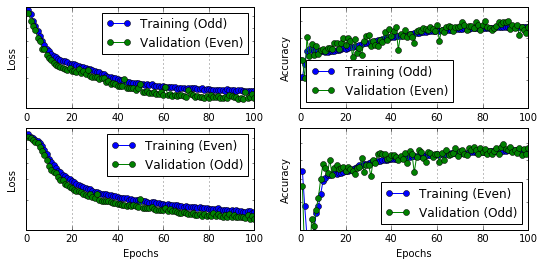

In [14]:
"""
overtraining test
"""
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)
plt.figure(figsize=(9, 4))
#fig = plt.figure(figsize=(4, 4))
#plt.subplot(1, 2, 1)
plt.subplot(2, 2, 1)
# Extract loss on training and validation dataset and plot them together
plt.plot(epochs, history.history["loss"], "o-", label="Training (Odd)")
plt.plot(epochs, history.history["val_loss"], "o-", label="Validation (Even)")
plt.xlabel("Epochs"), plt.ylabel("Loss")
plt.yscale("log")
#plt.xlim(0,40)
plt.ylim(0.2,0.8)
plt.grid()
plt.legend(loc="best");

#plt.subplot(1, 2, 2)
plt.subplot(2, 2, 2)
#fig = plt.figure(figsize=(4, 4))
# Extract loss on training and validation dataset and plot them together
plt.plot(epochs, history.history["acc"], "o-", label="Training (Odd)")
plt.plot(epochs, history.history["val_acc"], "o-", label="Validation (Even)")
plt.xlabel("Epochs"), plt.ylabel("Accuracy")
plt.yscale("log")
plt.ylim(0.4,0.9)
plt.grid()
plt.legend(loc="best")

plt.subplot(2, 2, 3)
# Extract loss on training and validation dataset and plot them together
plt.plot(epochs, history2.history["loss"], "o-", label="Training (Even)")
plt.plot(epochs, history2.history["val_loss"], "o-", label="Validation (Odd)")
plt.xlabel("Epochs"), plt.ylabel("Loss")
plt.yscale("log")
#plt.xlim(0,40)
plt.ylim(0.2,0.8)
plt.grid()
plt.legend(loc="best");

plt.subplot(2, 2, 4)
#fig = plt.figure(figsize=(4, 4))
# Extract loss on training and validation dataset and plot them together
plt.plot(epochs, history2.history["acc"], "o-", label="Training (Even)")
plt.plot(epochs, history2.history["val_acc"], "o-", label="Validation (Odd)")
plt.xlabel("Epochs"), plt.ylabel("Accuracy")
plt.yscale("log")
plt.ylim(0.4,0.9)
plt.grid()
plt.legend(loc="best")

filename1="{}/loss_and_acc_{}_Log.pdf".format(channel, hyppar) ## For gen_mHH as input Var.
#filename1="{}/loss_and_acc_{}_Log.pdf".format(channel, hyppar2) ## w/o gen_mHH as input Var.
plt.savefig(filename1);

plt.show()

In [10]:
import sys
sys.path.append('/home/ram/.local/lib/python2.7/site-packages')
import eli5
from eli5.sklearn import PermutationImportance
#from eli5.sklearn import permutation_importance
"""
to calculate variables importance, it takes time and it is not completelly 'enlightant',
do not do all the time.
"""

ImportError: No module named typing

In [16]:
print ("Date: ", time.asctime( time.localtime(time.time()) ))
perm = PermutationImportance(k_model_binary, random_state=1).fit( # , scoring="f1_samples"
    data_odd[features].values, ## For gen_mHH as input Var.
    #data_odd[features2].values, ## w/o gen_mHH as input Var.
    data_odd['target'].values,
    sample_weight=data_odd["weight_train"].values
)
print ("Date: ", time.asctime( time.localtime(time.time()) ))
eli5.show_weights(perm, feature_names = data_odd[features].columns.tolist(), top=len(features)) ## For gen_mHH as input Var.
#eli5.show_weights(perm, feature_names = data_odd[features2].columns.tolist(), top=len(features2)) ## w/o gen_mHH as input Var.

print ("Date: ", time.asctime( time.localtime(time.time()) ))
perm2 = PermutationImportance(k_model_binary2, random_state=1).fit( # , scoring="f1_samples"
    data_even[features].values, ## For gen_mHH as input Var.
    #data_even[features2].values, ## w/o gen_mHH as input Var.
    data_even['target'].values,
    sample_weight=data_even["weight_train"].values
)
print ("Date: ", time.asctime( time.localtime(time.time()) ))
eli5.show_weights(perm2, feature_names = data_even[features].columns.tolist(), top=len(features)) ## For gen_mHH as input Var.
#eli5.show_weights(perm2, feature_names = data_even[features2].columns.tolist(), top=len(features2)) ## w/o gen_mHH as input Var.

('Date: ', 'Thu Oct 17 18:48:03 2019')


NameError: name 'PermutationImportance' is not defined

In [15]:
"""
Calculate the output in all dataset 
-- to pass to the training/test
"""

## For gen_mHH as input Var.
data_odd["NN_output"]  = k_model_binary.predict_proba(data_odd[features].values, verbose=1)[:, 1]
data_even["NN_output"] = k_model_binary2.predict_proba(data_even[features].values, verbose=1)[:, 1]

## w/o gen_mHH as input Var.
#data_odd["NN_output"]  = k_model_binary.predict_proba(data_odd[features2].values, verbose=1)[:, 1]
#data_even["NN_output"] = k_model_binary2.predict_proba(data_even[features2].values, verbose=1)[:, 1]



342913/342913 [==============================] - 2s 7us/step


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


344624/344624 [==============================] - 2s 7us/step


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


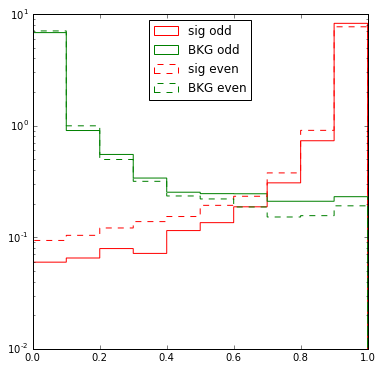

In [16]:
hist_params = {'normed': True, 'bins': 10 , 'histtype':'step'}
target = 'target'
plt.clf()

plt.figure('XGB',figsize=(6, 6))

values, bins, _ = plt.hist(
    data_odd.loc[data_odd.target.values == 1, "NN_output"].values , 
    weights=data_odd.loc[data_odd.target.values == 1, "weight_cx"].values,
    label="sig odd", color='r', range=(0,1), **hist_params
    )
values, bins, _ = plt.hist(
    data_odd.loc[data_odd.target.values == 0, "NN_output"].values , 
    weights=data_odd.loc[data_odd.target.values == 0, "weight_cx"].values,
    label="BKG odd", color='g', range=(0,1), **hist_params
    )

values, bins, _ = plt.hist(
    data_even.loc[data_even.target.values == 1, "NN_output"].values , 
    weights=(data_even.loc[data_even.target.values == 1, "weight_cx"].values),
    label="sig even", color='r', ls='--', range=(0,1), **hist_params)
values, bins, _ = plt.hist(
    data_even.loc[data_even.target.values == 0, "NN_output"].values , 
    weights=(data_even.loc[data_even.target.values == 0, "weight_cx"].values),
    label="BKG even", color='g', ls='--', range=(0,1), **hist_params)

#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper center')
#filename2="{}/NN_Output_{}.pdf".format(channel, hyppar) ## For gen_mHH as input Var.
filename2="{}/NN_Output_{}.pdf".format(channel, hyppar2) ## w/o gen_mHH as input Var.
plt.savefig(filename2);

plt.show()



train set auc 0.9809486948382142
test set auc 0.9781335924808773
train set auc 0.9781335924808773
test set auc 0.9809486948382142


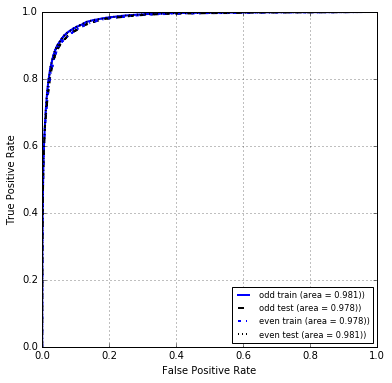

In [17]:
###############################
# ROC Curve
styleline = ['-', '--', '-.', ':']
colors_mass = ['m', 'b', 'k', 'r', 'g',  'y', 'c', ]
fig, ax = plt.subplots(figsize=(6, 6))
sl = 0

for dd, data_do in  enumerate(order_train) :
        if dd == 0 : val_data = 1
        else : val_data = 0
        #print data_do["weight_cx"].astype(np.float64)  
        #print data_do.NN_output.values
        fpr, tpr, thresholds = roc_curve(
                data_do["target"].astype(np.bool), 
                data_do.NN_output.values, 
                sample_weight=data_do["weight_cx"].astype(np.float64)
        )
        train_auc = auc(fpr, tpr, reorder = True)
        print("train set auc " + str(train_auc))
        fprt, tprt, thresholds = roc_curve(
            order_train[val_data]["target"].astype(np.bool), 
            order_train[val_data].NN_output.values, 
            sample_weight=(order_train[val_data]["weight_cx"].astype(np.float64))
        )
        test_auct = auc(fprt, tprt, reorder = True)
        print("test set auc " + str(test_auct))
        ax.plot(
            fpr, tpr,
            lw = 2, linestyle = styleline[dd + dd*1], color = colors_mass[1],
            label = order_train_name[dd] + ' train (area = %0.3f)'%(train_auc) + ")"
            )
        sl += 1
        ax.plot(
            fprt, tprt,
            lw = 2, linestyle = styleline[dd + 1 + + dd*1], color = colors_mass[2],
            label = order_train_name[dd] + ' test (area = %0.3f)'%(test_auct) + ")"
            )
        sl += 1
ax.set_ylim([0.0,1.0])
ax.set_xlim([0.0,1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right", fontsize = 'small')
ax.grid()

#filename2a="{}/ROC_{}.pdf".format(channel, hyppar) ## For gen_mHH as input Var.
filename2a="{}/ROC_{}.pdf".format(channel, hyppar2) ## w/o gen_mHH as input Var.
plt.savefig(filename2a);


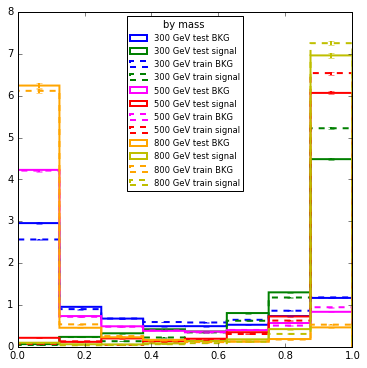

In [18]:
###############################
## classifier plot by mass
hist_params = {'normed': True, 'bins': 8 , 'histtype':'step', "lw": 2}
plt.clf()
colorcold = ['g', 'r', 'y']
colorhot = ['b', 'magenta', 'orange']

fig, ax = plt.subplots(figsize=(6, 6))
for mm, mass in enumerate(output["masses_test"]) :
    y_pred = data_even.loc[(data_even.target.values == 0) & (data_even["gen_mHH"] == mass), "NN_output"].values
    y_predS = data_even.loc[(data_even.target.values == 1) & (data_even["gen_mHH"] == mass), "NN_output"].values
    y_pred_train = data_odd.loc[(data_odd.target.values == 0) & (data_odd["gen_mHH"] == mass), "NN_output"].values
    y_predS_train = data_odd.loc[(data_odd.target.values == 1) & (data_odd["gen_mHH"] == mass), "NN_output"].values
    dict_plot = [
       [y_pred, "-", colorhot[mm],  str(mass)+" GeV test BKG"],
       [y_predS, "-", colorcold[mm], str(mass)+" GeV test signal"],
       [y_pred_train, "--", colorhot[mm], str(mass)+" GeV train BKG" ],
       [y_predS_train, "--", colorcold[mm],      str(mass)+" GeV train signal"]
    ]
    for item in dict_plot :
        values1, bins, _ = ax.hist(
            item[0],
            ls=item[1], color = item[2],
            label=item[3],
            range=(0,1),
            **hist_params
            )
        normed = sum(y_pred)
        mid = 0.5*(bins[1:] + bins[:-1])
        err=np.sqrt(values1*normed)/normed # denominator is because plot is normalized
        plt.errorbar(mid, values1, yerr=err, fmt='none', color= item[2], ecolor= item[2], edgecolor=item[2], lw=2)
#plt.xscale('log')
#plt.yscale('log')
ax.legend(loc='upper center', title="by mass ", fontsize = 'small')
#nameout = channel+'/'+bdtType+'_'+trainvar+'_'+str(len(trainVars(False)))+'_'+hyppar+'_mass_'+ str(mass)+'_XGBclassifier.pdf'

filename3="{}/NN_Output_by_mass_{}.pdf".format(channel, hyppar) ## For gen_mHH as input Var.
#filename3="{}/NN_Output_by_mass_{}.pdf".format(channel, hyppar2) ## w/o gen_mHH as input Var.
plt.savefig(filename3);

train set auc 0.9457770324961696 (mass = 300)
test set auc 0.9356753031509119 (mass = 300)
train set auc 0.9356753031509119 (mass = 300)
test set auc 0.9457770324961696 (mass = 300)
train set auc 0.9774220739318171 (mass = 500)
test set auc 0.9633723312257252 (mass = 500)
train set auc 0.9633723312257252 (mass = 500)
test set auc 0.9774220739318171 (mass = 500)
train set auc 0.991027872202709 (mass = 800)
test set auc 0.9913860967469242 (mass = 800)
train set auc 0.9913860967469242 (mass = 800)
test set auc 0.991027872202709 (mass = 800)


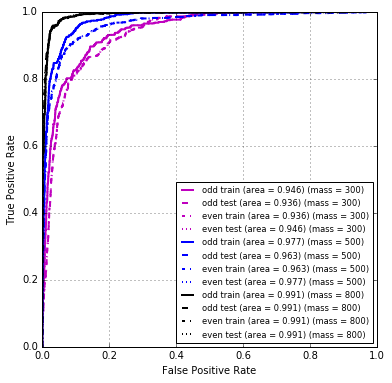

In [19]:
###############################
# by mass ROC
styleline = ['-', '--', '-.', ':']
colors_mass = ['m', 'b', 'k', 'r', 'g',  'y', 'c', ]
fig, ax = plt.subplots(figsize=(6, 6))
sl = 0


for mm, mass in enumerate(output["masses_test"]) :
    for dd, data_do in  enumerate(order_train) :
        if dd == 0 : val_data = 1
        else : val_data = 0
        fpr, tpr, thresholds = roc_curve(
            data_do.loc[(data_do["gen_mHH"] == mass), "target"].astype(np.bool),
            data_do.loc[(data_do["gen_mHH"] == mass), "NN_output"].values,
            sample_weight=(data_do.loc[(data_do["gen_mHH"].astype(np.int) == int(mass)), "weight_cx"].astype(np.float64))
        )
        train_auc = auc(fpr, tpr, reorder = True)
        print("train set auc " + str(train_auc) + " (mass = " + str(mass) + ")")
        fprt, tprt, thresholds = roc_curve(
            order_train[val_data].loc[(order_train[val_data]["gen_mHH"].astype(np.int) == int(mass)), target].astype(np.bool), 
            order_train[val_data].loc[(order_train[val_data]["gen_mHH"] == mass), "NN_output"].values, #proba[:,1],
            sample_weight=(order_train[val_data].loc[(order_train[val_data]["gen_mHH"].astype(np.int) == int(mass)), "weight_cx"].astype(np.float64))
        )
        test_auct = auc(fprt, tprt, reorder = True)
        print("test set auc " + str(test_auct) + " (mass = " + str(mass) + ")")
        ax.plot(
            fpr, tpr,
            lw = 2, linestyle = styleline[dd + dd*1], color = colors_mass[mm],
            label = order_train_name[dd] + ' train (area = %0.3f)'%(train_auc) + " (mass = " + str(mass) + ")"
            )
        sl += 1
        ax.plot(
            fprt, tprt,
            lw = 2, linestyle = styleline[dd + 1 + + dd*1], color = colors_mass[mm],
            label = order_train_name[dd] + ' test (area = %0.3f)'%(test_auct) + " (mass = " + str(mass) + ")"
            )
        sl += 1
ax.set_ylim([0.0,1.0])
ax.set_xlim([0.0,1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right", fontsize = 'small')
ax.grid()

filename4="{}/ROC_by_mass_{}.pdf".format(channel, hyppar) ## For gen_mHH as input Var.
#filename4="{}/ROC_by_mass_{}.pdf".format(channel, hyppar2) ## w/o gen_mHH as input Var.
plt.savefig(filename4);


('mass', 300)
('MASS', 300)
('MASS_STR', '300')
Using the old logic
Train on 324608 samples, validate on 18428 samples
Epoch 1/100
 - 9s - loss: 0.8545 - acc: 0.2743 - val_loss: 0.7269 - val_acc: 0.2333
Epoch 2/100
 - 9s - loss: 0.7461 - acc: 0.2627 - val_loss: 0.6923 - val_acc: 0.2338
Epoch 3/100
 - 9s - loss: 0.6744 - acc: 0.3220 - val_loss: 0.6714 - val_acc: 0.2336
Epoch 4/100
 - 9s - loss: 0.6436 - acc: 0.3503 - val_loss: 0.6629 - val_acc: 0.2336
Epoch 5/100
 - 9s - loss: 0.6215 - acc: 0.3846 - val_loss: 0.6525 - val_acc: 0.2446
Epoch 6/100
 - 9s - loss: 0.6019 - acc: 0.4285 - val_loss: 0.6426 - val_acc: 0.3510
Epoch 7/100
 - 9s - loss: 0.5814 - acc: 0.4877 - val_loss: 0.6352 - val_acc: 0.4314
Epoch 8/100
 - 9s - loss: 0.5619 - acc: 0.5269 - val_loss: 0.6286 - val_acc: 0.4500
Epoch 9/100
 - 9s - loss: 0.5443 - acc: 0.5561 - val_loss: 0.6201 - val_acc: 0.4971
Epoch 10/100
 - 9s - loss: 0.5300 - acc: 0.5718 - val_loss: 0.6144 - val_acc: 0.4868
Epoch 11/100
 - 9s - loss: 0.5157 - acc:

 - 9s - loss: 0.2500 - acc: 0.7657 - val_loss: 0.3780 - val_acc: 0.5904
Epoch 97/100
 - 8s - loss: 0.2518 - acc: 0.7670 - val_loss: 0.3719 - val_acc: 0.6245
Epoch 98/100
 - 8s - loss: 0.2501 - acc: 0.7662 - val_loss: 0.3778 - val_acc: 0.6427
Epoch 99/100
 - 8s - loss: 0.2503 - acc: 0.7670 - val_loss: 0.3789 - val_acc: 0.6188
Epoch 100/100
 - 8s - loss: 0.2484 - acc: 0.7675 - val_loss: 0.3705 - val_acc: 0.6443
 8192/18428 [============>.................] - ETA: 0s

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


  9472/324608 [..............................] - ETA: 1s

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


324608/324608 [==============================] - 2s 7us/step


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:117: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:118: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

S

Train on 324608 samples, validate on 18428 samples
Epoch 1/35
 - 10s - loss: 0.5467 - acc: 0.5088 - val_loss: 0.5323 - val_acc: 0.4092
Epoch 2/35
 - 9s - loss: 0.3557 - acc: 0.6418 - val_loss: 0.4718 - val_acc: 0.4556
Epoch 3/35
 - 8s - loss: 0.3117 - acc: 0.6946 - val_loss: 0.4276 - val_acc: 0.4908
Epoch 4/35
 - 9s - loss: 0.2899 - acc: 0.7231 - val_loss: 0.3914 - val_acc: 0.5358
Epoch 5/35
 - 9s - loss: 0.2737 - acc: 0.7402 - val_loss: 0.3671 - val_acc: 0.5777
Epoch 6/35
 - 9s - loss: 0.2646 - acc: 0.7520 - val_loss: 0.3616 - val_acc: 0.5695
Epoch 7/35
 - 9s - loss: 0.2547 - acc: 0.7577 - val_loss: 0.3610 - val_acc: 0.5753
Epoch 8/35
 - 8s - loss: 0.2481 - acc: 0.7637 - val_loss: 0.3471 - val_acc: 0.5942
Epoch 9/35
 - 8s - loss: 0.2443 - acc: 0.7698 - val_loss: 0.3526 - val_acc: 0.5869
Epoch 10/35
 - 8s - loss: 0.2410 - acc: 0.7715 - val_loss: 0.3346 - val_acc: 0.6121
Epoch 11/35
 - 9s - loss: 0.2378 - acc: 0.7744 - val_loss: 0.3368 - val_acc: 0.6144
Epoch 12/35
 - 9s - loss: 0.2367 

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 17152/324608 [>.............................] - ETA: 1s

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


324608/324608 [==============================] - 2s 7us/step


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:260: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:261: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

S

Using the old logic
Train on 18305 samples, validate on 18428 samples
Epoch 1/35
 - 2s - loss: 0.7405 - acc: 0.4438 - val_loss: 0.6886 - val_acc: 0.4846
Epoch 2/35
 - 1s - loss: 0.6233 - acc: 0.4257 - val_loss: 0.6267 - val_acc: 0.5055
Epoch 3/35
 - 1s - loss: 0.5696 - acc: 0.4176 - val_loss: 0.5875 - val_acc: 0.5246
Epoch 4/35
 - 1s - loss: 0.5399 - acc: 0.4561 - val_loss: 0.5544 - val_acc: 0.5567
Epoch 5/35
 - 1s - loss: 0.5033 - acc: 0.4797 - val_loss: 0.5302 - val_acc: 0.5605
Epoch 6/35
 - 1s - loss: 0.4860 - acc: 0.4792 - val_loss: 0.5093 - val_acc: 0.5497
Epoch 7/35
 - 1s - loss: 0.4719 - acc: 0.4907 - val_loss: 0.4936 - val_acc: 0.5441
Epoch 8/35
 - 1s - loss: 0.4537 - acc: 0.5118 - val_loss: 0.4831 - val_acc: 0.5365
Epoch 9/35
 - 1s - loss: 0.4386 - acc: 0.5056 - val_loss: 0.4715 - val_acc: 0.5317
Epoch 10/35
 - 1s - loss: 0.4355 - acc: 0.5104 - val_loss: 0.4621 - val_acc: 0.5371
Epoch 11/35
 - 1s - loss: 0.4159 - acc: 0.5112 - val_loss: 0.4550 - val_acc: 0.5276
Epoch 12/35
 - 

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:409: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


18428/18428 [==============================] - 0s 18us/step
('fprt3', array([0.        , 0.        , 0.        , ..., 0.99998356, 0.99998521,
       1.        ]))
('tprt3', array([0.00133329, 0.00388429, 0.00618357, ..., 1.        , 1.        ,
       1.        ]))
18305/18305 [==============================] - 0s 6us/step


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:411: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:424: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based

Using the old logic
Train on 326196 samples, validate on 18305 samples
Epoch 1/100
 - 11s - loss: 0.7820 - acc: 0.4847 - val_loss: 0.7366 - val_acc: 0.2369
Epoch 2/100
 - 9s - loss: 0.6831 - acc: 0.4062 - val_loss: 0.6873 - val_acc: 0.2207
Epoch 3/100
 - 9s - loss: 0.6499 - acc: 0.3307 - val_loss: 0.6672 - val_acc: 0.2180
Epoch 4/100
 - 9s - loss: 0.6257 - acc: 0.3415 - val_loss: 0.6633 - val_acc: 0.2150
Epoch 5/100
 - 9s - loss: 0.5885 - acc: 0.4066 - val_loss: 0.6591 - val_acc: 0.2128
Epoch 6/100
 - 9s - loss: 0.5552 - acc: 0.4642 - val_loss: 0.6449 - val_acc: 0.2430
Epoch 7/100
 - 9s - loss: 0.5218 - acc: 0.5150 - val_loss: 0.6321 - val_acc: 0.3019
Epoch 8/100
 - 9s - loss: 0.4903 - acc: 0.5571 - val_loss: 0.6073 - val_acc: 0.2878
Epoch 9/100
 - 9s - loss: 0.4655 - acc: 0.5870 - val_loss: 0.5939 - val_acc: 0.3862
Epoch 10/100
 - 9s - loss: 0.4449 - acc: 0.6112 - val_loss: 0.5873 - val_acc: 0.4146
Epoch 11/100
 - 9s - loss: 0.4307 - acc: 0.6159 - val_loss: 0.5810 - val_acc: 0.4550
Ep

Epoch 97/100
 - 9s - loss: 0.2406 - acc: 0.7736 - val_loss: 0.3345 - val_acc: 0.6363
Epoch 98/100
 - 9s - loss: 0.2392 - acc: 0.7739 - val_loss: 0.3313 - val_acc: 0.6431
Epoch 99/100
 - 9s - loss: 0.2395 - acc: 0.7730 - val_loss: 0.3340 - val_acc: 0.6368
Epoch 100/100
 - 9s - loss: 0.2393 - acc: 0.7736 - val_loss: 0.3294 - val_acc: 0.6444
326196/326196 [==============================] - 2s 7us/step
Train on 326196 samples, validate on 18305 samples
Epoch 1/35
 - 10s - loss: 0.4703 - acc: 0.6630 - val_loss: 0.5242 - val_acc: 0.3929
Epoch 2/35
 - 8s - loss: 0.3498 - acc: 0.6453 - val_loss: 0.4234 - val_acc: 0.4734
Epoch 3/35
 - 8s - loss: 0.2951 - acc: 0.7177 - val_loss: 0.3951 - val_acc: 0.5159
Epoch 4/35
 - 8s - loss: 0.2735 - acc: 0.7448 - val_loss: 0.3776 - val_acc: 0.5533
Epoch 5/35
 - 9s - loss: 0.2643 - acc: 0.7565 - val_loss: 0.3680 - val_acc: 0.5700
Epoch 6/35
 - 9s - loss: 0.2596 - acc: 0.7609 - val_loss: 0.3594 - val_acc: 0.5907
Epoch 7/35
 - 8s - loss: 0.2551 - acc: 0.7669 - 

Epoch 15/100
 - 9s - loss: 0.4071 - acc: 0.6323 - val_loss: 0.3934 - val_acc: 0.6735
Epoch 16/100
 - 8s - loss: 0.4021 - acc: 0.6331 - val_loss: 0.3914 - val_acc: 0.6028
Epoch 17/100
 - 9s - loss: 0.3976 - acc: 0.6295 - val_loss: 0.3864 - val_acc: 0.6729
Epoch 18/100
 - 9s - loss: 0.3938 - acc: 0.6340 - val_loss: 0.4061 - val_acc: 0.5605
Epoch 19/100
 - 8s - loss: 0.3904 - acc: 0.6312 - val_loss: 0.3800 - val_acc: 0.6149
Epoch 20/100
 - 8s - loss: 0.3863 - acc: 0.6329 - val_loss: 0.3833 - val_acc: 0.6019
Epoch 21/100
 - 9s - loss: 0.3831 - acc: 0.6364 - val_loss: 0.3681 - val_acc: 0.6564
Epoch 22/100
 - 9s - loss: 0.3792 - acc: 0.6359 - val_loss: 0.3659 - val_acc: 0.6622
Epoch 23/100
 - 9s - loss: 0.3747 - acc: 0.6359 - val_loss: 0.3666 - val_acc: 0.6242
Epoch 24/100
 - 9s - loss: 0.3681 - acc: 0.6397 - val_loss: 0.3634 - val_acc: 0.6385
Epoch 25/100
 - 9s - loss: 0.3641 - acc: 0.6410 - val_loss: 0.3743 - val_acc: 0.5823
Epoch 26/100
 - 9s - loss: 0.3628 - acc: 0.6392 - val_loss: 0.361

Epoch 10/35
 - 8s - loss: 0.2486 - acc: 0.7720 - val_loss: 0.2481 - val_acc: 0.7672
Epoch 11/35
 - 8s - loss: 0.2485 - acc: 0.7736 - val_loss: 0.2448 - val_acc: 0.7736
Epoch 12/35
 - 8s - loss: 0.2448 - acc: 0.7748 - val_loss: 0.2410 - val_acc: 0.7676
Epoch 13/35
 - 8s - loss: 0.2427 - acc: 0.7753 - val_loss: 0.2427 - val_acc: 0.7575
Epoch 14/35
 - 8s - loss: 0.2427 - acc: 0.7783 - val_loss: 0.2410 - val_acc: 0.7554
Epoch 15/35
 - 8s - loss: 0.2392 - acc: 0.7790 - val_loss: 0.2399 - val_acc: 0.7625
Epoch 16/35
 - 8s - loss: 0.2386 - acc: 0.7802 - val_loss: 0.2342 - val_acc: 0.7724
Epoch 17/35
 - 8s - loss: 0.2385 - acc: 0.7814 - val_loss: 0.2325 - val_acc: 0.7843
Epoch 18/35
 - 8s - loss: 0.2382 - acc: 0.7819 - val_loss: 0.2326 - val_acc: 0.7667
Epoch 19/35
 - 8s - loss: 0.2365 - acc: 0.7809 - val_loss: 0.2378 - val_acc: 0.7685
Epoch 20/35
 - 8s - loss: 0.2378 - acc: 0.7821 - val_loss: 0.2332 - val_acc: 0.7651
Epoch 21/35
 - 8s - loss: 0.2362 - acc: 0.7822 - val_loss: 0.2277 - val_acc:

Epoch 31/100
 - 8s - loss: 0.3187 - acc: 0.7036 - val_loss: 0.2931 - val_acc: 0.7243
Epoch 32/100
 - 8s - loss: 0.3199 - acc: 0.7044 - val_loss: 0.3008 - val_acc: 0.6345
Epoch 33/100
 - 8s - loss: 0.3142 - acc: 0.7095 - val_loss: 0.2961 - val_acc: 0.6428
Epoch 34/100
 - 8s - loss: 0.3172 - acc: 0.7120 - val_loss: 0.2875 - val_acc: 0.7362
Epoch 35/100
 - 8s - loss: 0.3117 - acc: 0.7134 - val_loss: 0.2903 - val_acc: 0.7262
Epoch 36/100
 - 9s - loss: 0.3101 - acc: 0.7140 - val_loss: 0.2833 - val_acc: 0.7361
Epoch 37/100
 - 9s - loss: 0.3122 - acc: 0.7156 - val_loss: 0.2839 - val_acc: 0.6749
Epoch 38/100
 - 9s - loss: 0.3089 - acc: 0.7146 - val_loss: 0.2745 - val_acc: 0.7225
Epoch 39/100
 - 9s - loss: 0.3093 - acc: 0.7192 - val_loss: 0.3158 - val_acc: 0.7876
Epoch 40/100
 - 9s - loss: 0.3058 - acc: 0.7186 - val_loss: 0.3035 - val_acc: 0.6217
Epoch 41/100
 - 9s - loss: 0.3050 - acc: 0.7237 - val_loss: 0.2763 - val_acc: 0.7430
Epoch 42/100
 - 9s - loss: 0.3027 - acc: 0.7237 - val_loss: 0.275

Epoch 26/35
 - 8s - loss: 0.2223 - acc: 0.7971 - val_loss: 0.1910 - val_acc: 0.7806
Epoch 27/35
 - 8s - loss: 0.2206 - acc: 0.7953 - val_loss: 0.1919 - val_acc: 0.7745
Epoch 28/35
 - 8s - loss: 0.2215 - acc: 0.7957 - val_loss: 0.1938 - val_acc: 0.7751
Epoch 29/35
 - 8s - loss: 0.2189 - acc: 0.7968 - val_loss: 0.1935 - val_acc: 0.7810
Epoch 30/35
 - 8s - loss: 0.2168 - acc: 0.7958 - val_loss: 0.1933 - val_acc: 0.7843
Epoch 31/35
 - 8s - loss: 0.2184 - acc: 0.7977 - val_loss: 0.1931 - val_acc: 0.7807
Epoch 32/35
 - 8s - loss: 0.2179 - acc: 0.7974 - val_loss: 0.1905 - val_acc: 0.7761
Epoch 33/35
 - 8s - loss: 0.2193 - acc: 0.7975 - val_loss: 0.1900 - val_acc: 0.7799
Epoch 34/35
 - 8s - loss: 0.2190 - acc: 0.7962 - val_loss: 0.1886 - val_acc: 0.7797
Epoch 35/35
 - 8s - loss: 0.2152 - acc: 0.7975 - val_loss: 0.1893 - val_acc: 0.7848
325860/325860 [==============================] - 2s 7us/step
Using the old logic
Train on 18764 samples, validate on 18632 samples
Epoch 1/35
 - 4s - loss: 0.84

Epoch 46/100
 - 9s - loss: 0.2925 - acc: 0.7161 - val_loss: 0.1381 - val_acc: 0.8407
Epoch 47/100
 - 9s - loss: 0.2875 - acc: 0.7181 - val_loss: 0.1349 - val_acc: 0.8409
Epoch 48/100
 - 9s - loss: 0.2854 - acc: 0.7191 - val_loss: 0.1335 - val_acc: 0.8692
Epoch 49/100
 - 9s - loss: 0.2870 - acc: 0.7203 - val_loss: 0.1413 - val_acc: 0.8810
Epoch 50/100
 - 9s - loss: 0.2880 - acc: 0.7219 - val_loss: 0.1474 - val_acc: 0.8856
Epoch 51/100
 - 8s - loss: 0.2847 - acc: 0.7233 - val_loss: 0.1369 - val_acc: 0.8154
Epoch 52/100
 - 8s - loss: 0.2861 - acc: 0.7246 - val_loss: 0.1434 - val_acc: 0.8960
Epoch 53/100
 - 8s - loss: 0.2814 - acc: 0.7248 - val_loss: 0.1299 - val_acc: 0.8521
Epoch 54/100
 - 8s - loss: 0.2829 - acc: 0.7241 - val_loss: 0.1385 - val_acc: 0.8883
Epoch 55/100
 - 8s - loss: 0.2823 - acc: 0.7274 - val_loss: 0.1281 - val_acc: 0.8474
Epoch 56/100
 - 8s - loss: 0.2811 - acc: 0.7263 - val_loss: 0.1357 - val_acc: 0.8831
Epoch 57/100
 - 9s - loss: 0.2755 - acc: 0.7300 - val_loss: 0.154

Epoch 4/35
 - 1s - loss: 0.4763 - acc: 0.6460 - val_loss: 0.4429 - val_acc: 0.6613
Epoch 5/35
 - 1s - loss: 0.4250 - acc: 0.6945 - val_loss: 0.3966 - val_acc: 0.6925
Epoch 6/35
 - 1s - loss: 0.3771 - acc: 0.7196 - val_loss: 0.3543 - val_acc: 0.6937
Epoch 7/35
 - 1s - loss: 0.3387 - acc: 0.7326 - val_loss: 0.3134 - val_acc: 0.7196
Epoch 8/35
 - 1s - loss: 0.3033 - acc: 0.7464 - val_loss: 0.2815 - val_acc: 0.7334
Epoch 9/35
 - 1s - loss: 0.2716 - acc: 0.7520 - val_loss: 0.2532 - val_acc: 0.7476
Epoch 10/35
 - 1s - loss: 0.2522 - acc: 0.7672 - val_loss: 0.2292 - val_acc: 0.7689
Epoch 11/35
 - 1s - loss: 0.2317 - acc: 0.7881 - val_loss: 0.2120 - val_acc: 0.7934
Epoch 12/35
 - 1s - loss: 0.2204 - acc: 0.8110 - val_loss: 0.1959 - val_acc: 0.8202
Epoch 13/35
 - 1s - loss: 0.2079 - acc: 0.8249 - val_loss: 0.1842 - val_acc: 0.8403
Epoch 14/35
 - 1s - loss: 0.1968 - acc: 0.8361 - val_loss: 0.1756 - val_acc: 0.8532
Epoch 15/35
 - 1s - loss: 0.1880 - acc: 0.8458 - val_loss: 0.1676 - val_acc: 0.861

Epoch 62/100
 - 9s - loss: 0.2997 - acc: 0.7290 - val_loss: 0.1576 - val_acc: 0.8734
Epoch 63/100
 - 9s - loss: 0.2982 - acc: 0.7306 - val_loss: 0.1590 - val_acc: 0.8359
Epoch 64/100
 - 9s - loss: 0.2979 - acc: 0.7295 - val_loss: 0.1572 - val_acc: 0.8359
Epoch 65/100
 - 9s - loss: 0.2964 - acc: 0.7308 - val_loss: 0.1581 - val_acc: 0.8281
Epoch 66/100
 - 8s - loss: 0.2919 - acc: 0.7334 - val_loss: 0.1991 - val_acc: 0.7439
Epoch 67/100
 - 9s - loss: 0.2942 - acc: 0.7316 - val_loss: 0.1527 - val_acc: 0.8588
Epoch 68/100
 - 9s - loss: 0.2948 - acc: 0.7344 - val_loss: 0.1531 - val_acc: 0.8715
Epoch 69/100
 - 9s - loss: 0.2908 - acc: 0.7343 - val_loss: 0.3074 - val_acc: 0.6103
Epoch 70/100
 - 9s - loss: 0.2914 - acc: 0.7368 - val_loss: 0.1509 - val_acc: 0.8600
Epoch 71/100
 - 10s - loss: 0.2903 - acc: 0.7367 - val_loss: 0.1636 - val_acc: 0.8262
Epoch 72/100
 - 9s - loss: 0.2887 - acc: 0.7376 - val_loss: 0.1688 - val_acc: 0.8970
Epoch 73/100
 - 9s - loss: 0.2859 - acc: 0.7387 - val_loss: 0.16

Epoch 20/35
 - 1s - loss: 0.1513 - acc: 0.8458 - val_loss: 0.1725 - val_acc: 0.8478
Epoch 21/35
 - 1s - loss: 0.1485 - acc: 0.8487 - val_loss: 0.1707 - val_acc: 0.8500
Epoch 22/35
 - 1s - loss: 0.1469 - acc: 0.8521 - val_loss: 0.1678 - val_acc: 0.8573
Epoch 23/35
 - 1s - loss: 0.1462 - acc: 0.8513 - val_loss: 0.1673 - val_acc: 0.8593
Epoch 24/35
 - 1s - loss: 0.1467 - acc: 0.8566 - val_loss: 0.1668 - val_acc: 0.8578
Epoch 25/35
 - 1s - loss: 0.1411 - acc: 0.8620 - val_loss: 0.1651 - val_acc: 0.8628
Epoch 26/35
 - 1s - loss: 0.1400 - acc: 0.8615 - val_loss: 0.1647 - val_acc: 0.8617
Epoch 27/35
 - 1s - loss: 0.1397 - acc: 0.8644 - val_loss: 0.1626 - val_acc: 0.8680
Epoch 28/35
 - 1s - loss: 0.1351 - acc: 0.8658 - val_loss: 0.1625 - val_acc: 0.8670
Epoch 29/35
 - 1s - loss: 0.1377 - acc: 0.8698 - val_loss: 0.1620 - val_acc: 0.8672
Epoch 30/35
 - 1s - loss: 0.1360 - acc: 0.8756 - val_loss: 0.1604 - val_acc: 0.8744
Epoch 31/35
 - 1s - loss: 0.1316 - acc: 0.8739 - val_loss: 0.1583 - val_acc:

'       \nax1.set_ylim([0.0,1.0])\nax1.set_xlim([0.0,1.0])\nax1.set_xlabel(\'False Positive Rate\')\nax1.set_ylabel(\'True Positive Rate\')\nax1.legend(loc="lower right", fontsize = \'small\')\nax1.grid()\nfilename4a="{}/ROC_Interpol_BDT_w_genmHH_{}.pdf".format(channel, hyppar) ## For gen_mHH as input Var.\n#filename4="{}/ROC_by_mass_{}.pdf".format(channel, hyppar2) ## w/o gen_mHH as input Var.\nplt2.savefig(filename4a);\n\nax2.set_ylim([0.0,1.0])\nax2.set_xlim([0.0,1.0])\nax2.set_xlabel(\'False Positive Rate\')\nax2.set_ylabel(\'True Positive Rate\')\nax2.legend(loc="upper left", fontsize = \'small\')\nax2.grid()\nfilename4b="{}/ROC_Interpol_BDT_wo_genmHH_{}.pdf".format(channel, hyppar) ## For gen_mHH as input Var.\nplt2.savefig(filename4b);\n\nax3.set_ylim([0.0,1.0])\nax3.set_xlim([0.0,1.0])\nax3.set_xlabel(\'False Positive Rate\')\nax3.set_ylabel(\'True Positive Rate\')\nax3.legend(loc="upper left", fontsize = \'small\')\nax3.grid()\nfilename4c="{}/ROC_Single_Mass_wo_genmHH_{}.pdf".

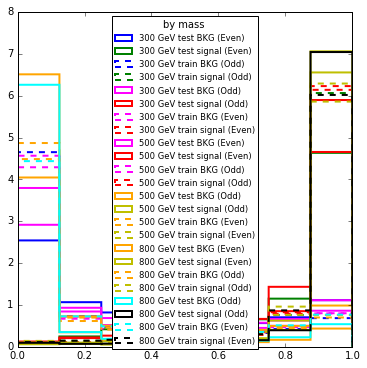

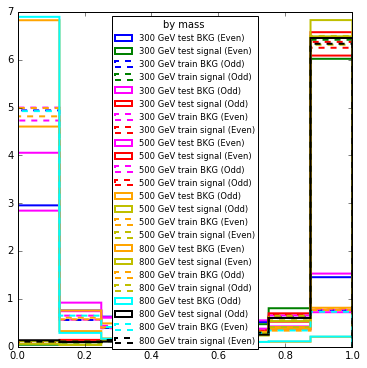

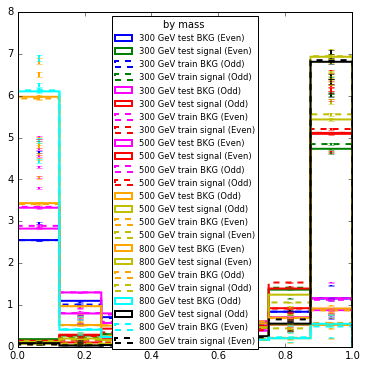

In [20]:
import matplotlib.pyplot as plt2

features = trainvar # = BDTvariables
features2 = BDTvariables_wo_gen_mHH

#### ----- Interpolation check log files ----####                                                                                                                                                                                                                       
styleline = ['-', '--', '-.', ':', 'solid']
colors_mass = ['m', 'b', 'k', 'r', 'g',  'y', 'c', ]
## ---- ROC CURVES ------###
#fig1, ax1 = plt2.subplots(figsize=(6, 6))
#fig2, ax2 = plt2.subplots(figsize=(6, 6))
#fig3, ax3 = plt2.subplots(figsize=(6, 6))
#sl = 0
#s2 = 0
#s3 = 0

hist_params = {'normed': True, 'bins': 8 , 'histtype':'step', "lw": 2}
plt.clf()
colorcold = ['g', 'r', 'y', 'black', 'gray']
colorhot = ['b', 'magenta', 'orange', 'cyan', 'brown']
## ---- NN OUTPUT ---- ###
fig1a, ax1a = plt.subplots(figsize=(6, 6))
fig1b, ax1b = plt.subplots(figsize=(6, 6))
fig1c, ax1c = plt.subplots(figsize=(6, 6))

for mm, mass in enumerate(test_masses): ## Loop over the test masses   
#for mm, mass in enumerate([300]): ## Loop over 300 GeV test mass only      
    print("mass", mass)
    MASS = int(mass)
    print("MASS", MASS)
    MASS_STR = "{}".format(MASS)
    print("MASS_STR", MASS_STR)
    
    ## For writing the interpolation check roc curves ##
    log_file2_name = "{}/{}_{}.log".format(channel,channel,MASS_STR)
    file2_ = open(log_file2_name, 'w+')

    for dd, data_do in  enumerate(order_train):   ## Loop over the odd and even dataset halves                                                                                                                                                                          
        if dd == 0 : val_data = 1
        else : val_data = 0
        
        if(Bkg_mass_rand == "default"):
            print("Using the new logic")
            traindataset1 = data_do.loc[~((data_do["gen_mHH"]==mass) & (data_do['target']==1))]  ## Training for all masses except the one under study only for signal process                                                                                            
            #valdataset1   = order_train[val_data].loc[~((order_train[val_data]["gen_mHH"]==mass) & (order_train[val_data][target]==1))]  ## Testing for all masses except the one under study for signal process                                                       
            valdataset1 = order_train[val_data].loc[~((order_train[val_data]["gen_mHH"]!=mass) & (order_train[val_data]['target']==1))] ## Testing on only the mass under study for signal                                                                                
        else:
            print("Using the old logic")
            traindataset1 = data_do.loc[~(data_do["gen_mHH"]==mass)]  ## Training for all masses except the one under study                                                                                                                                             
            #valdataset1 = order_train[val_data].loc[~(order_train[val_data]["gen_mHH"]==mass)]  ## Testing for all masses except the one under study                                                                                                                   
            valdataset1 = order_train[val_data].loc[(order_train[val_data]["gen_mHH"]==mass)] ## Testing on only the mass under study
        
        
        if(mass == 300):
            if(TrainMode == 0):
                masses1 = [250,260,270,280,350,400,450,500,550,600,650,700,750,800,850,900,1000] ## All masses except 300                                                                                                                                               
                masses_test1 = [250,1000]
            elif(TrainMode == 1):
                masses1 = [250,260,270,280,350,400] ## Low mass only training (except 300)                                                                                                                                                                              
                masses_test1 = [250]
            masses2 = [300]
            masses_test2 = [300]
        elif(mass == 500):
            if(TrainMode == 0):
                masses1 = [250,260,270,280,300,350,400,450,550,600,650,700,750,800,850,900,1000] ## All masses except 500                                                                                                                                               
                masses_test1 = [250,1000]
            elif(TrainMode == 2):
                masses1 = [450,550,600,650,700,750,800,850,900,1000] ## High mass only training (except 500)                                                                                                                                                            
                masses_test1 = [1000]
            masses2 = [500]
            masses_test2 = [500]
        elif(mass == 800):
            if(TrainMode == 0):
                masses1 = [250,260,270,280,300,350,400,450,500,550,600,650,700,750,850,900,1000] ## All masses except 800                                                                                                                                               
                masses_test1 = [250,1000]
            elif(TrainMode == 2):
                masses1 = [450,500,550,600,650,700,750,850,900,1000] ## High mass only training (except 800)                                                                                                                                                            
                masses_test1 = [1000]
            masses2 = [800]
            masses_test2 = [800]
           
        
        ################# WITH gen_mHH #####################                                                                                                                                                                                                            
        k_model_binary2  = KerasClassifier(
                       build_fn=nn_model_binary, 
                       epochs=EPOCHS, # 10
                       batch_size=BATCH_SIZE, # 64
                       verbose=2
                       )
        
        history2 = k_model_binary2.fit(
               traindataset1[features].values, 
               traindataset1['target'].values,
               sample_weight=traindataset1["weight_train"].values,
               validation_data=(
                   valdataset1[features].values, 
                   valdataset1['target'].values, 
                   valdataset1["weight_train"].values
               )
        )

        traindataset1["NN_output2"] = 1.0
        valdataset1["NN_output2"]   = 1.0
        
        ## --- ROC curve ----##                                                                                                                                                                                                                                         
        #proba = cls2.predict_proba(valdataset1[trainVars(False, options.variables, options.bdtType)].values )
        valdataset1["NN_output2"] = k_model_binary2.predict_proba(valdataset1[features].values, verbose=1)[:, 1]
        fprt, tprt, thresholds = roc_curve(valdataset1['target'].astype(np.bool), valdataset1["NN_output2"].values, sample_weight=(valdataset1["weight_cx"].astype(np.float64)) )
        test_auct = auc(fprt, tprt, reorder = True)

        #proba = cls2.predict_proba(traindataset1[trainVars(False, options.variables, options.bdtType)].values )
        traindataset1["NN_output2"] = k_model_binary2.predict_proba(traindataset1[features].values, verbose=1)[:, 1]
        fpr, tpr, thresholds = roc_curve(traindataset1['target'].astype(np.bool), traindataset1["NN_output2"].values, sample_weight=(traindataset1["weight_cx"].astype(np.float64)) )
        train_auc = auc(fpr, tpr, reorder = True)

        ## ---- BDT Output Distributions ----- ###                                                                                                                                                                                                                      
        y_pred = k_model_binary2.predict_proba(valdataset1.ix[valdataset1.target.values == 0, BDTvariables].values)[:, 1]
        y_predS = k_model_binary2.predict_proba(valdataset1.ix[valdataset1.target.values == 1, BDTvariables].values)[:, 1]
        
        y_pred_train = k_model_binary2.predict_proba(traindataset1.ix[traindataset1.target.values == 0, BDTvariables].values)[:, 1]
        y_predS_train = k_model_binary2.predict_proba(traindataset1.ix[traindataset1.target.values == 1, BDTvariables].values)[:, 1]

        file2_.write('#------ Training for all masses except %0.1f GeV-------\n' %mass)
        file2_.write('#------ Testing only for mass %0.1f GeV (using other dataset half)--------\n' %mass)
        if(dd == 0): ## Train->odd; Test/val -> even                                                                                                                                                                                                                    
            file2_.write('train_auc_ODD0_%s = %0.8f\n' % (MASS_STR, train_auc))
            file2_.write('test_auc_EVEN0_%s  = %0.8f\n' % (MASS_STR, test_auct))
            file2_.write('xtrain_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(fpr.tolist()))
            file2_.write('\n')
            file2_.write('ytrain_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(tpr.tolist()))
            file2_.write('\n')
            file2_.write('xval_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(fprt.tolist()))
            file2_.write('\n')
            file2_.write('yval_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(tprt.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_test_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(y_pred.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_test_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(y_predS.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_train_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_train.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_train_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_train.tolist()))
            file2_.write('\n')
        else: ## Train->even; Test/val -> odd                                                                                                                                                                                                                           
            file2_.write('train_auc_EVEN0_%s = %0.8f\n' %  (MASS_STR, train_auc))
            file2_.write('test_auc_ODD0_%s  = %0.8f\n' %  (MASS_STR, test_auct))
            file2_.write('xtrain_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(fpr.tolist()))
            file2_.write('\n')
            file2_.write('ytrain_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(tpr.tolist()))
            file2_.write('\n')
            file2_.write('xval_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(fprt.tolist()))
            file2_.write('\n')
            file2_.write('yval_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(tprt.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_test_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(y_pred.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_test_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(y_predS.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_train_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_train.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_train_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_train.tolist()))
            file2_.write('\n')
        file2_.write('##-------------------------------------------##\n')
        ################################################### 
        
        ## ---- ROC curves ---###
        #ax1.plot( 
        #    fpr, tpr,
        #    lw = 2, linestyle = styleline[dd + dd*1], color = colors_mass[0],
        #    label = order_train_name[dd] + ' train all except %s GeV w gen_mHH (area = %0.3f)'%(str(mass), train_auc)
        #    )
        #sl += 1
        #ax1.plot(
        #    fprt, tprt,
        #    lw = 2, linestyle = styleline[dd + 1 + + dd*1], color = colors_mass[0],
        #    label = order_train_name[dd] + ' test only %s GeV w gen_mHH (area = %0.3f)'%(str(mass), test_auct)
        #    )
        #sl += 1
        
        ## Plot NN Output Histograms
        if dd == 0 : # Odd train, Even test
            dict_plot = [ ## Output Histogtams
                   [y_pred, "-", colorhot[mm],  str(mass)+" GeV test BKG (Even)"],
                   [y_predS, "-", colorcold[mm], str(mass)+" GeV test signal (Even)"],
                   [y_pred_train, "--", colorhot[mm], str(mass)+" GeV train BKG (Odd)" ],
                   [y_predS_train, "--", colorcold[mm],      str(mass)+" GeV train signal (Odd)"]
                ]
        else: # Even train, Odd test
            dict_plot = [ ## Output Histogtams
                   [y_pred, "-", colorhot[mm+1],  str(mass)+" GeV test BKG (Odd)"],
                   [y_predS, "-", colorcold[mm+1], str(mass)+" GeV test signal (Odd)"],
                   [y_pred_train, "--", colorhot[mm+1], str(mass)+" GeV train BKG (Even)" ],
                   [y_predS_train, "--", colorcold[mm+1],      str(mass)+" GeV train signal (Even)"]
                ]
            
        for item in dict_plot :
            values1, bins, _ = ax1a.hist(
                item[0],
                ls=item[1], color = item[2],
                label=item[3],
                range=(0,1),
                **hist_params
                )
            normed = sum(y_pred)
            mid = 0.5*(bins[1:] + bins[:-1])
            err=np.sqrt(values1*normed)/normed # denominator is because plot is normalized
            plt.errorbar(mid, values1, yerr=err, fmt='none', color= item[2], ecolor= item[2], edgecolor=item[2], lw=2)
        del dict_plot[:] ## Clearing the list    
        
        ################# W/O gen_mHH #####################                                                                                                                                                                                                             
        k_model_binary2a = KerasClassifier(
                       build_fn=nn_model_binary_wo_gen_mHH, 
                       epochs=EPOCHS2, # 10
                       batch_size=BATCH_SIZE2, # 64
                       verbose=2
                       )

        history2a = k_model_binary2a.fit(
               traindataset1[BDTvariables_wo_gen_mHH].values, 
               traindataset1['target'].values,
               sample_weight=traindataset1["weight_train"].values,
               validation_data=(
                   valdataset1[BDTvariables_wo_gen_mHH].values, 
                   valdataset1['target'].values, 
                   valdataset1["weight_train"].values
               )
        )

        traindataset1["NN_output2a"] = 1.0
        valdataset1["NN_output2a"]   = 1.0
        
        ## --- ROC curve ----##                                                                                                                                                                                                                                         
        #proba_a = cls2a.predict_proba(valdataset1[BDTvariables_wo_gen_mHH].values )
        valdataset1["NN_output2a"] = k_model_binary2a.predict_proba(valdataset1[BDTvariables_wo_gen_mHH].values , verbose=1)[:, 1]
        fprt_a, tprt_a, thresholds = roc_curve(valdataset1['target'].astype(np.bool), valdataset1["NN_output2a"].values, sample_weight=(valdataset1["weight_cx"].astype(np.float64))  )
        test_auct_a = auc(fprt_a, tprt_a, reorder = True)

        #proba_a = cls2a.predict_proba(traindataset1[BDTvariables_wo_gen_mHH].values )
        traindataset1["NN_output2a"] = k_model_binary2a.predict_proba(traindataset1[BDTvariables_wo_gen_mHH].values , verbose=1)[:, 1]
        fpr_a, tpr_a, thresholds = roc_curve(traindataset1['target'].astype(np.bool), traindataset1["NN_output2a"].values, sample_weight=(traindataset1["weight_cx"].astype(np.float64)) )
        train_auc_a = auc(fpr_a, tpr_a, reorder = True)

        ## ---- BDT Output Distributions ----- ###                                                                                                                                                                                                                      
        y_pred_a = k_model_binary2a.predict_proba(valdataset1.ix[valdataset1.target.values == 0, BDTvariables_wo_gen_mHH].values)[:, 1]
        y_predS_a = k_model_binary2a.predict_proba(valdataset1.ix[valdataset1.target.values == 1, BDTvariables_wo_gen_mHH].values)[:, 1]

        y_pred_train_a = k_model_binary2a.predict_proba(traindataset1.ix[traindataset1.target.values == 0, BDTvariables_wo_gen_mHH].values)[:, 1]
        y_predS_train_a = k_model_binary2a.predict_proba(traindataset1.ix[traindataset1.target.values == 1, BDTvariables_wo_gen_mHH].values)[:, 1]
        
        file2_.write('#------ Training for all masses except %0.1f GeV (w/o gen_mHH)-------\n' %mass)
        file2_.write('#------ Testing only for mass %0.1f GeV using other dataset half (w/o gen_mHH)--------\n' %mass)
        if(dd == 0): ## Train->odd; Test/val -> even                                                                                                                                                                                                                    
            file2_.write('train_auc_ODD0a_%s = %0.8f\n' % (MASS_STR, train_auc_a))
            file2_.write('test_auc_EVEN0a_%s  = %0.8f\n' % (MASS_STR, test_auct_a))
            file2_.write('xtrain_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(fpr_a.tolist()))
            file2_.write('\n')
            file2_.write('ytrain_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(tpr_a.tolist()))
            file2_.write('\n')
            file2_.write('xval_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(fprt_a.tolist()))
            file2_.write('\n')
            file2_.write('yval_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(tprt_a.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_test_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_a.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_test_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_a.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_train_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_train_a.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_train_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_train_a.tolist()))
            file2_.write('\n')
        else: ## Train->even; Test/val -> odd                                                                                                                                                                                                                           
            file2_.write('train_auc_EVEN0a_%s = %0.8f\n' %  (MASS_STR, train_auc_a))
            file2_.write('test_auc_ODD0a_%s  = %0.8f\n' %  (MASS_STR, test_auct_a))
            file2_.write('xtrain_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(fpr_a.tolist()))
            file2_.write('\n')
            file2_.write('ytrain_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(tpr_a.tolist()))
            file2_.write('\n')
            file2_.write('xval_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(fprt_a.tolist()))
            file2_.write('\n')
            file2_.write('yval_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(tprt_a.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_test_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_a.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_test_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_a.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_train_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_train_a.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_train_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_train_a.tolist()))
            file2_.write('\n')
        file2_.write('##-------------------------------------------##\n')
        ################################################### 
        
        ## --- ROC Curves --- ##
        #ax2.plot(
        #    fpr_a, tpr_a,
        #    lw = 2, linestyle = styleline[dd + dd*1], color = colors_mass[1],
        #    label = order_train_name[dd] + ' train all except %s GeV w/o gen_mHH (area = %0.3f)'%(str(mass), train_auc_a)
        #    )
        #s2 += 1
        #ax2.plot(
        #    fprt_a, tprt_a,
        #    lw = 2, linestyle = styleline[dd + 1 + + dd*1], color = colors_mass[1],
        #    label = order_train_name[dd] + ' test only %s GeV w/o gen_mHH (area = %0.3f)'%(str(mass), test_auct_a)
        #    )
        #s2 += 1
        
        ## Plot NN Output Histograms
        if dd == 0 : # Odd train, Even test
            dict_plot2 = [ ## Output Histogtams
                   [y_pred_a, "-", colorhot[mm],  str(mass)+" GeV test BKG (Even)"],
                   [y_predS_a, "-", colorcold[mm], str(mass)+" GeV test signal (Even)"],
                   [y_pred_train_a, "--", colorhot[mm], str(mass)+" GeV train BKG (Odd)" ],
                   [y_predS_train_a, "--", colorcold[mm],      str(mass)+" GeV train signal (Odd)"]
                ]
        else: # Even train, Odd test
            dict_plot2 = [ ## Output Histogtams
                   [y_pred_a, "-", colorhot[mm+1],  str(mass)+" GeV test BKG (Odd)"],
                   [y_predS_a, "-", colorcold[mm+1], str(mass)+" GeV test signal (Odd)"],
                   [y_pred_train_a, "--", colorhot[mm+1], str(mass)+" GeV train BKG (Even)" ],
                   [y_predS_train_a, "--", colorcold[mm+1],      str(mass)+" GeV train signal (Even)"]
                ]
            
        for item in dict_plot2 :
            values1, bins, _ = ax1b.hist(
                item[0],
                ls=item[1], color = item[2],
                label=item[3],
                range=(0,1),
                **hist_params
                )
            normed = sum(y_pred_a)
            mid = 0.5*(bins[1:] + bins[:-1])
            err=np.sqrt(values1*normed)/normed # denominator is because plot is normalized
            plt.errorbar(mid, values1, yerr=err, fmt='none', color= item[2], ecolor= item[2], edgecolor=item[2], lw=2)
        del dict_plot2[:] ## Clearing the list 
            
        ## --- Single Mass training ----##                                                                                                                                                                                                                                         
        if(Bkg_mass_rand == "default"):
            print("Using the new logic")
            #traindataset2 = data_do.loc[(data_do["gen_mHH"]==mass)]  ## Training for only the mass point under study                                                                                                                                                   
            traindataset2 = data_do.loc[ ~((data_do["gen_mHH"]!=mass) & (data_do['target']==1)) ]  ## Training for only the mass point under study (for the signal process)                                                                                               
            valdataset2 = order_train[val_data].loc[ ~((order_train[val_data]["gen_mHH"]!=mass) & (order_train[val_data]['target']==1)) ]  ## Testing for only the mass point under study (for the signal process)                                                        
        else:
            print("Using the old logic")
            traindataset2 = data_do.loc[(data_do["gen_mHH"]==mass)]  ## Training for only the mass point under study                                                                                                                                                    
            valdataset2 = order_train[val_data].loc[(order_train[val_data]["gen_mHH"]==mass)]  ## Testing for only the mass point under study                                                                                                                           

        #traindataset2 = data_do.loc[(data_do["gen_mHH"]==mass)]  ## Training for only the mass point under study                                                                                                                                                       
        #valdataset2 = order_train[val_data].loc[(order_train[val_data]["gen_mHH"]==mass)]  ## Testing for only the mass point under study                                                                                                                              

       
        k_model_binary3 = KerasClassifier(
                       build_fn=nn_model_binary_wo_gen_mHH, 
                       epochs=EPOCHS2, # 10
                       batch_size=BATCH_SIZE2, # 64
                       verbose=2
                       #build_fn=nn_model_binary, 
                       #epochs=EPOCHS, # 10
                       #batch_size=BATCH_SIZE, # 64
                       #verbose=2
                       )
        
        history3 = k_model_binary3.fit(
               traindataset2[BDTvariables_wo_gen_mHH].values, ## Since we are doing single mass train no need for gen_mHH
               #traindataset2[BDTvariables].values,
               traindataset2['target'].values,
               sample_weight=traindataset2["weight_train"].values,
               validation_data=(
                   valdataset2[BDTvariables_wo_gen_mHH].values,
                   #valdataset2[BDTvariables].values,
                   valdataset2['target'].values, 
                   valdataset2["weight_train"].values
               )
        )
        
        traindataset2["NN_output3"] = 1.0
        valdataset2["NN_output3"]   = 1.0
        
        valdataset2["NN_output3"] = k_model_binary3.predict_proba(valdataset2[BDTvariables_wo_gen_mHH].values , verbose=1)[:, 1] ## Since we are doing single mass train no need for gen_mHH
        #valdataset2["NN_output3"] = k_model_binary3.predict_proba(valdataset2[BDTvariables].values )
        fprt3, tprt3, thresholds3 = roc_curve(valdataset2['target'].astype(np.bool), valdataset2["NN_output3"].values, sample_weight=(valdataset2["weight_cx"].astype(np.float64))  )
        print("fprt3", fprt3)
        print("tprt3", tprt3)
        test_auct = auc(fprt3, tprt3, reorder = True)

        traindataset2["NN_output3"] = k_model_binary3.predict_proba(traindataset2[BDTvariables_wo_gen_mHH].values , verbose=1)[:, 1] ## Since we are doing single mass train no need for gen_mHH                                                                                                                          
        #traindataset2["NN_output3"] = k_model_binary3.predict_proba(traindataset2[BDTvariables].values )
        fpr3, tpr3, thresholds3 = roc_curve(traindataset2['target'].astype(np.bool), traindataset2["NN_output3"].values, sample_weight=(traindataset2["weight_cx"].astype(np.float64)) )
        train_auc = auc(fpr3, tpr3, reorder = True)

        ## ---- BDT Output Distributions ----- ###                                                                                                                                                                                                                      
        y_pred_3 = k_model_binary3.predict_proba(valdataset2.ix[valdataset2.target.values == 0, BDTvariables_wo_gen_mHH].values)[:, 1]   ## Since we are doing single mass train no need for gen_mHH                                                                                 
        y_predS_3 = k_model_binary3.predict_proba(valdataset2.ix[valdataset2.target.values == 1, BDTvariables_wo_gen_mHH].values)[:, 1]  ## Since we are doing single mass train no need for gen_mHH                                                                                 

        y_pred_train_3 = k_model_binary3.predict_proba(traindataset2.ix[traindataset2.target.values == 0, BDTvariables_wo_gen_mHH].values)[:, 1]  ## Since we are doing single mass train no need for gen_mHH                                                                        
        y_predS_train_3 = k_model_binary3.predict_proba(traindataset2.ix[traindataset2.target.values == 1, BDTvariables_wo_gen_mHH].values)[:, 1] ## Since we are doing single mass train no need for gen_mHH 
  
        #y_pred_3 = k_model_binary3.predict_proba(valdataset2.ix[valdataset2.target.values == 0, BDTvariables].values)[:, 1]
        #y_predS_3 = k_model_binary3.predict_proba(valdataset2.ix[valdataset2.target.values == 1, BDTvariables].values)[:, 1]
    
        #y_pred_train_3 = k_model_binary3.predict_proba(traindataset2.ix[traindataset2.target.values == 0, BDTvariables].values)[:, 1]
        #y_predS_train_3 = k_model_binary3.predict_proba(traindataset2.ix[traindataset2.target.values == 1, BDTvariables].values)[:, 1] 
    
        file2_.write('#------ Training for only mass %0.1f GeV-------\n' %mass)
        file2_.write('#------ Testing for only mass %0.1f GeV (using other data half)--------\n' %mass)
        if(dd == 0): ## Train->odd; Test/val -> even                                                                                                                                                                                                                    
            file2_.write('train_auc_ODD1_%s = %0.8f\n' % (MASS_STR, train_auc))
            file2_.write('test_auc_EVEN1_%s  = %0.8f\n' % (MASS_STR, test_auct))
            file2_.write('xtrain_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(fpr3.tolist()))
            file2_.write('\n')
            file2_.write('ytrain_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(tpr3.tolist()))
            file2_.write('\n')
            file2_.write('xval_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(fprt3.tolist()))
            file2_.write('\n')
            file2_.write('yval_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(tprt3.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_test_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_3.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_test_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_3.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_train_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_train_3.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_train_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_train_3.tolist()))
            file2_.write('\n')
        else: ## Train->even; Test/val -> odd                                                                                                                                                                                                                           
            file2_.write('train_auc_EVEN1_%s = %0.8f\n' %  (MASS_STR, train_auc))
            file2_.write('test_auc_ODD1_%s  = %0.8f\n' % (MASS_STR, test_auct))
            file2_.write('xtrain_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(fpr3.tolist()))
            file2_.write('\n')
            file2_.write('ytrain_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(tpr3.tolist()))
            file2_.write('\n')
            file2_.write('xval_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(fprt3.tolist()))
            file2_.write('\n')
            file2_.write('yval_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(tprt3.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_test_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_3.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_test_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_3.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_train_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_train_3.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_train_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_train_3.tolist()))
            file2_.write('\n')
        file2_.write('##-------------------------------------------##\n')
        
        ## ---- ROC Curves ---- ##
        #ax3.plot(
        #    fpr3, tpr3,
        #    lw = 2, linestyle = styleline[dd + dd*1], color = colors_mass[2],
        #    label = order_train_name[dd] + ' Single mass train %s GeV (area = %0.3f)'%(str(mass), train_auc)
        #    )
        #s3 += 1
        #ax3.plot(
        #    fprt3, tprt3,
        #    lw = 2, linestyle = styleline[dd + 1 + + dd*1], color = colors_mass[2],
        #    label = order_train_name[dd] + ' Single mass test %s GeV (area = %0.3f)'%(str(mass), test_auct)
        #    )
        #s3 += 1
        
        
        ## Plot NN Output Histograms
        if dd == 0 : # Odd train, Even test
            dict_plot3 = [ ## Output Histogtams
                   [y_pred_3, "-", colorhot[mm],  str(mass)+" GeV test BKG (Even)"],
                   [y_predS_3, "-", colorcold[mm], str(mass)+" GeV test signal (Even)"],
                   [y_pred_train_3, "--", colorhot[mm], str(mass)+" GeV train BKG (Odd)" ],
                   [y_predS_train_3, "--", colorcold[mm],      str(mass)+" GeV train signal (Odd)"]
                ]
        else: # Even train, Odd test
            dict_plot3 = [ ## Output Histogtams
                   [y_pred_3, "-", colorhot[mm+1],  str(mass)+" GeV test BKG (Odd)"],
                   [y_predS_3, "-", colorcold[mm+1], str(mass)+" GeV test signal (Odd)"],
                   [y_pred_train_3, "--", colorhot[mm+1], str(mass)+" GeV train BKG (Even)" ],
                   [y_predS_train_3, "--", colorcold[mm+1], str(mass)+" GeV train signal (Even)"]
                ]
            
        for item in dict_plot3 :
            values1, bins, _ = ax1c.hist(
                item[0],
                ls=item[1], color = item[2],
                label=item[3],
                range=(0,1),
                **hist_params
                )
            normed = sum(y_pred_3)
            mid = 0.5*(bins[1:] + bins[:-1])
            err=np.sqrt(values1*normed)/normed # denominator is because plot is normalized
            plt.errorbar(mid, values1, yerr=err, fmt='none', color= item[2], ecolor= item[2], edgecolor=item[2], lw=2)
        del dict_plot3[:] ## Clearing the list
        
    file2_.close()
    
    #plt.yscale('log')
    ax1a.legend(loc='upper center', title="by mass ", fontsize = 'small')
    ax1b.legend(loc='upper center', title="by mass ", fontsize = 'small')
    ax1c.legend(loc='upper center', title="by mass ", fontsize = 'small')
    if dd == 0: # Odd train, Even test
        filename3a="{}/NN_Output_Odd_TrainOnAllExcept_{}_Even_TestOn_{}_w_gen_mHH_{}.pdf".format(channel, str(mass), str(mass), hyppar) ## For gen_mHH as input Var.
        fig1a.savefig(filename3a);
        filename3b="{}/NN_Output_Odd_TrainOnAllExcept_{}_Even_TestOn_{}_wo_gen_mHH_{}.pdf".format(channel, str(mass), str(mass), hyppar) ## For gen_mHH as input Var.
        fig1b.savefig(filename3b);
        filename3c="{}/NN_Output_Odd_TrainOnAllExcept_{}_Even_TestOn_{}_SingleMass_{}.pdf".format(channel, str(mass), str(mass), hyppar) ## For gen_mHH as input Var.
        fig1c.savefig(filename3c);
    else: # Even train, Odd test 
        filename3a="{}/NN_Output_Even_TrainOnAllExcept_{}_Odd_TestOn_{}_w_gen_mHH_{}.pdf".format(channel, str(mass), str(mass), hyppar) ## For gen_mHH as input Var.
        fig1a.savefig(filename3a);
        filename3b="{}/NN_Output_Even_TrainOnAllExcept_{}_Odd_TestOn_{}_wo_gen_mHH_{}.pdf".format(channel, str(mass), str(mass), hyppar) ## For gen_mHH as input Var.
        fig1b.savefig(filename3b);
        filename3c="{}/NN_Output_Even_TrainOnAllExcept_{}_Odd_TestOn_{}_SingleMass_{}.pdf".format(channel, str(mass), str(mass), hyppar) ## For gen_mHH as input Var.
        fig1c.savefig(filename3c);
       
'''       
ax1.set_ylim([0.0,1.0])
ax1.set_xlim([0.0,1.0])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right", fontsize = 'small')
ax1.grid()
filename4a="{}/ROC_Interpol_BDT_w_genmHH_{}.pdf".format(channel, hyppar) ## For gen_mHH as input Var.
#filename4="{}/ROC_by_mass_{}.pdf".format(channel, hyppar2) ## w/o gen_mHH as input Var.
plt2.savefig(filename4a);

ax2.set_ylim([0.0,1.0])
ax2.set_xlim([0.0,1.0])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend(loc="upper left", fontsize = 'small')
ax2.grid()
filename4b="{}/ROC_Interpol_BDT_wo_genmHH_{}.pdf".format(channel, hyppar) ## For gen_mHH as input Var.
plt2.savefig(filename4b);

ax3.set_ylim([0.0,1.0])
ax3.set_xlim([0.0,1.0])
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.legend(loc="upper left", fontsize = 'small')
ax3.grid()
filename4c="{}/ROC_Single_Mass_wo_genmHH_{}.pdf".format(channel, hyppar) ## For gen_mHH as input Var.
plt2.savefig(filename4c);
### ---------------------------------------- #### 
'''        
            

In [21]:
"""
output a training and export to .pb (to be used on cpp)
"""
print ("Date: ", time.asctime( time.localtime(time.time()) ))
nameout = "model_erase"

out = k_model_binary.model.save("test_"+nameout+"_"+hyppar+"_Odd.hdf5")
file = open(nameout+"_variables.log","w")
file.write(str(features)+"\n")
file.close()

out = k_model_binary2.model.save("test_"+nameout+"_"+hyppar+"_Even.hdf5")
file = open(nameout+"_variables.log","w")
file.write(str(features)+"\n")
file.close()


## This bellow does not work, easier to be done on the command line,
## in any case the bellow is a template how to run it
##!python ../test/convert_hdf5_2_pb.py --input "test_"+nameout+".hdf5" --output "test_"+nameout+".pb"

('Date: ', 'Fri Oct 18 18:03:35 2019')


In [ ]:
"""
If you want to load a model to reconpute anything or check loading just substitute k_model --> k_model_loaded
It only loads hdf5 format
"""
from keras.models import load_model
k_model_loaded = load_model("test_model_2lss_ttH_3cat_no4mom_noSemi_v6.hdf5")

In [22]:
## the next do correlation matrices with variables
import seaborn 

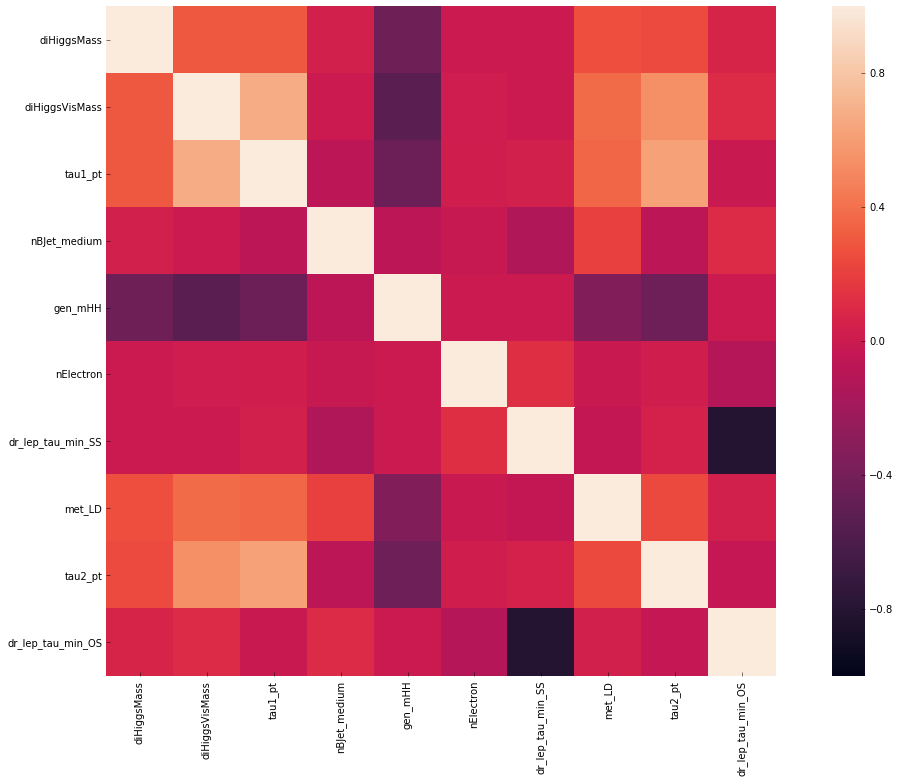

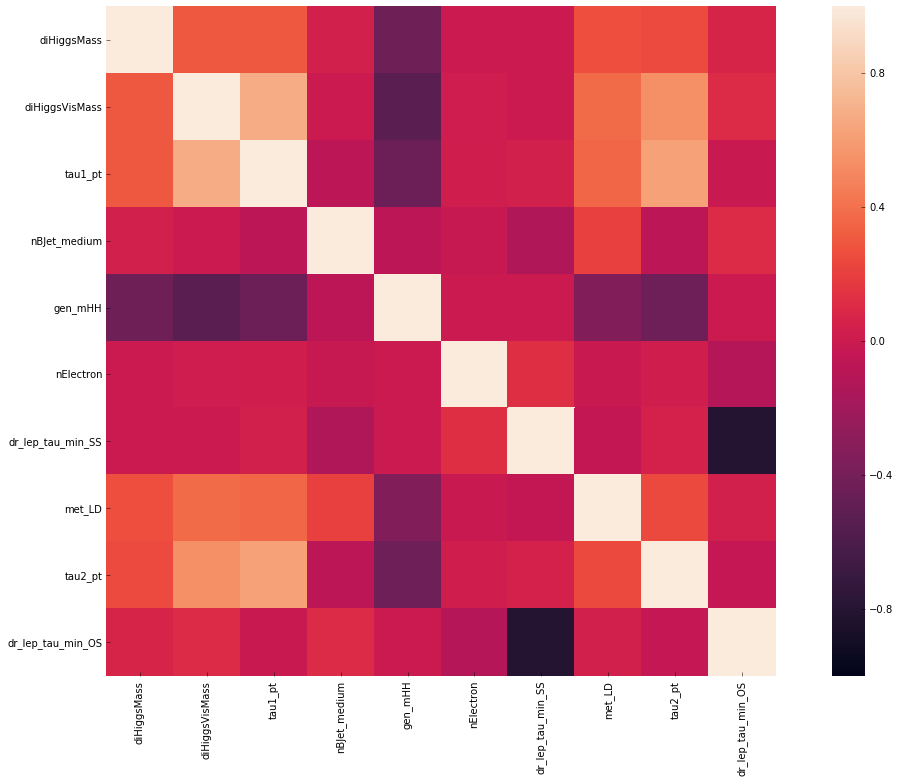

In [23]:
for target in [0,1] :
    corr_mat = data.loc[(data['target']==0), features].astype(float).corr() #
    fig, ax = plt.subplots(figsize=(20, 12)) 
    seaborn.heatmap(corr_mat, square=True, ax=ax, vmin=-1., vmax=1.)
    if(target == 0) : filename4="{}/Signal_Correl_{}.pdf".format(channel, hyppar)
    else: filename4="{}/Background_Correl_{}.pdf".format(channel, hyppar)   
    plt.savefig(filename4);